# Himydata Technical Test - Clustering Analysis

## Objectives:
1. Data Loading and Preprocessing
2. K-means Clustering Implementation
3. Gaussian Mixture Model (GMM) Implementation
4. DBSCAN Implementation
5. Comparison of Clustering Methods

# 1. Data Loading and Preprocessing

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import os
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.3f}'.format)

# Set plotting style and size
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)

In [5]:
def load_data(filepath='./data/combined_data.csv'):
    """Load the combined dataset"""
    df = pd.read_csv(filepath)
    print(f"Loaded data: {df.shape}")
    print(f"Number of products: {len(df)}")
    return df

# Load combined data
data = load_data()
data.head()

Loaded data: (444, 31)
Number of products: 444


,product_id,mean,std,min,max,range,high_state_mean,low_state_mean,high_state_ratio,high_state_std,low_state_std,transition_point,transition_magnitude,trend_slope,EPAI_COILC,LARGCOILVISC,Aluminium,Azote,Bore,Carbone,Chrome,Cuivre,Etain,Manganese,Molybdene,Nickel,Niobium,Phosphore,Silicium,Soufre,Titane
0,18N078,133.411,283.606,-200.885,652.753,853.638,345.123,-179.782,0.597,148.230,45.289,0.617,124.667,-2.900,2.820,954,675,28,0,17,260,283,36,925,18,143,0,78,48.000,73,687
1,18N079,153.950,292.944,-201.627,633.060,834.687,373.391,-179.822,0.603,139.544,39.166,0.563,138.840,-3.111,2.230,944,566,52,0,389,466,135,10,2555,6,131,3,95,91.000,116,8
2,18N080,112.410,254.275,-170.316,553.546,723.862,317.446,-155.713,0.567,128.749,17.215,0.567,56.607,-2.703,2.520,931,282,33,0,39,226,219,49,2355,8,134,2,89,33.000,90,1
3,18N081,111.614,250.718,-168.338,544.153,712.491,311.170,-152.913,0.570,129.670,27.973,0.523,67.236,-2.622,2.520,931,314,42,0,43,246,223,37,2411,11,134,2,79,26.000,87,1
4,18N082,96.938,248.724,-167.102,540.939,708.041,312.136,-152.321,0.537,120.304,25.473,0.537,66.989,-2.546,2.520,931,245,46,0,42,277,213,54,2418,10,144,2,91,33.000,70,1


In [6]:
def handle_missing_values(df):
    """Identify and handle missing values"""
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0]

    if len(missing_cols) > 0:
        print("\nColumns with missing values:")
        print(missing_cols)

        # Fill missing values with column means
        for col in missing_cols.index:
            df[col] = df[col].fillna(df[col].mean())
            print(f"Filled missing values in {col} with mean")
    else:
        print("\nNo missing values found in the dataset.")

    return df

# Handle missing values
data = handle_missing_values(data)


No missing values found in the dataset.


In [7]:
def select_and_scale_features(df):
    """Select relevant features and scale them for clustering"""
    # Time series features
    ts_features = [
        'mean', 'std', 'min', 'max', 'range',
        'high_state_mean', 'low_state_mean', 'high_state_ratio',
        'high_state_std', 'low_state_std', 'transition_point',
        'transition_magnitude', 'trend_slope'
    ]

    # Physical properties
    physical_features = ['EPAI_COILC', 'LARGCOILVISC']

    # Get all chemical elements (all columns except ID, time series features, and physical properties)
    exclude_cols = ['product_id'] + ts_features + physical_features
    chemical_features = [col for col in df.columns if col not in exclude_cols]

    # Combine all features
    selected_features = ts_features + physical_features + chemical_features

    # Create feature matrix
    X = df[selected_features].copy()

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert to DataFrame for better interpretability
    X_scaled_df = pd.DataFrame(
        data=X_scaled,
        columns=selected_features,
        index=X.index
    )

    print(f"Selected {len(selected_features)} features for clustering")
    print(f"Feature matrix shape: {X_scaled.shape}")

    return X, X_scaled, X_scaled_df, selected_features, scaler

# Scale the dataset
X, X_scaled, X_scaled_df, selected_features, scaler = select_and_scale_features(data)

Selected 30 features for clustering
Feature matrix shape: (444, 30)


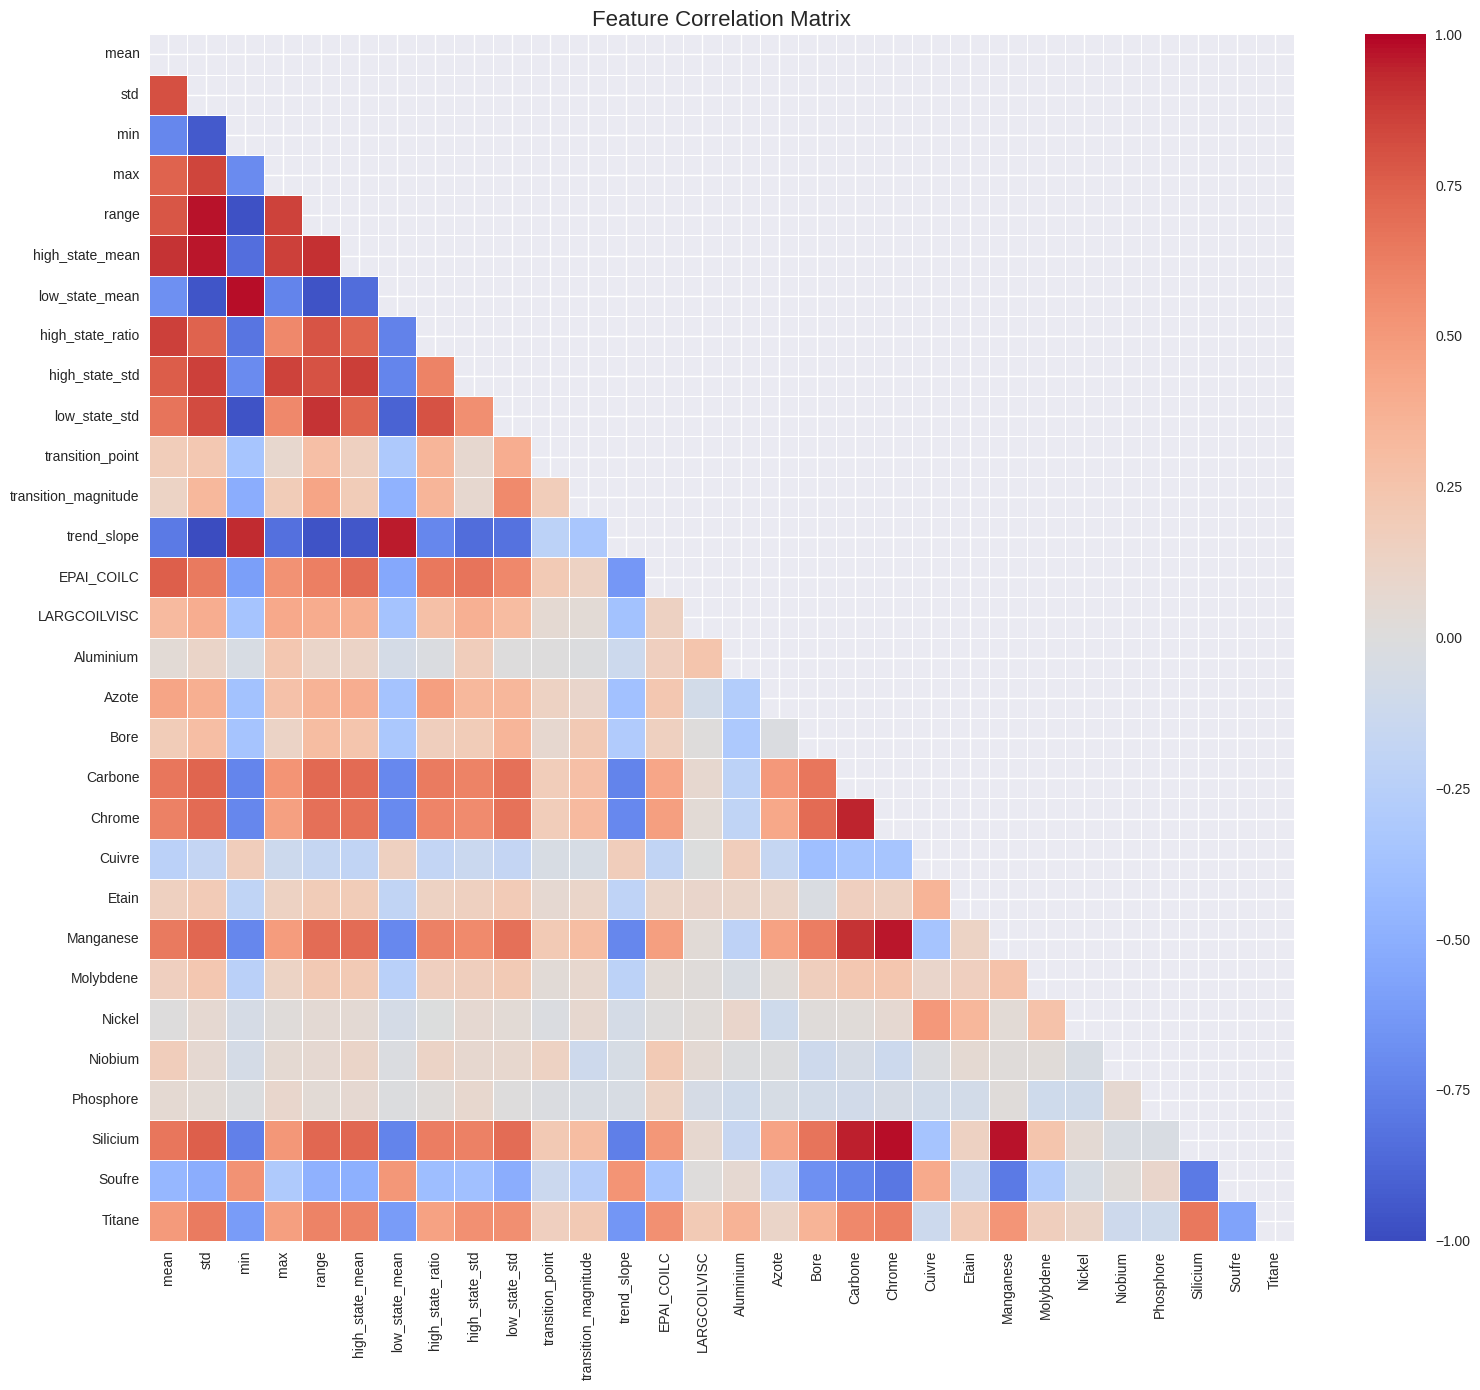


Identifying highly correlated features (|r| > 0.9):
Highly correlated features:
mean & high_state_mean: 0.904
std & min: 0.932
std & range: 0.970
std & high_state_mean: 0.962
std & low_state_mean: 0.954
std & trend_slope: 0.996
min & std: 0.932
min & range: 0.970
min & low_state_mean: 0.979
min & low_state_std: 0.963
min & trend_slope: 0.929
range & std: 0.970
range & min: 0.970
range & high_state_mean: 0.908
range & low_state_mean: 0.966
range & low_state_std: 0.903
range & trend_slope: 0.963
high_state_mean & mean: 0.904
high_state_mean & std: 0.962
high_state_mean & range: 0.908
high_state_mean & trend_slope: 0.952
low_state_mean & std: 0.954
low_state_mean & min: 0.979
low_state_mean & range: 0.966
low_state_mean & trend_slope: 0.954
low_state_std & min: 0.963
low_state_std & range: 0.903
trend_slope & std: 0.996
trend_slope & min: 0.929
trend_slope & range: 0.963
trend_slope & high_state_mean: 0.952
trend_slope & low_state_mean: 0.954
Carbone & Chrome: 0.942
Carbone & Manganese: 

In [9]:
def plot_correlation_matrix(X):
    """Plot correlation matrix of features"""
    plt.figure(figsize=(16, 14))
    correlation_matrix = X.corr()
    mask = np.triu(correlation_matrix)
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm',
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.savefig('results/correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nIdentifying highly correlated features (|r| > 0.9):")
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr = [(col1, col2, corr_matrix.loc[col1, col2])
                  for col1 in corr_matrix.columns
                  for col2 in corr_matrix.columns
                  if corr_matrix.loc[col1, col2] > 0.9 and col1 != col2]

    if high_corr:
        print("Highly correlated features:")
        for col1, col2, val in high_corr:
            print(f"{col1} & {col2}: {val:.3f}")
    else:
        print("No feature pairs with correlation > 0.9 found.")

# Create output directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Plot correlation matrix
plot_correlation_matrix(X)

- Manganese, Carbone, Chrome, and Silicium show the strongest correlations with time series features, validating our earlier discussion about their importance.
- Manganese in particular has strong positive correlations with mean, high_state_mean and other operational parameters, suggesting it significantly influences manufacturing behavior.
- Chrome and Carbone show similar correlation patterns, indicating they may affect the manufacturing process in related ways.
- EPAI_COILC (thickness): Shows moderate correlations with several time series features, suggesting product thickness affects sensor readings during manufacturing.
Correlates with certain chemical elements, particularly Carbone, indicating specific composition requirements for different thickness products.
- LARGCOILVISC (width): Has weaker correlations overall compared to thickness, suggesting width may be less influential on the sensor readings being analyzed.

PCA explained variance ratio: [0.46491135 0.09885052]
Total explained variance: 56.38%


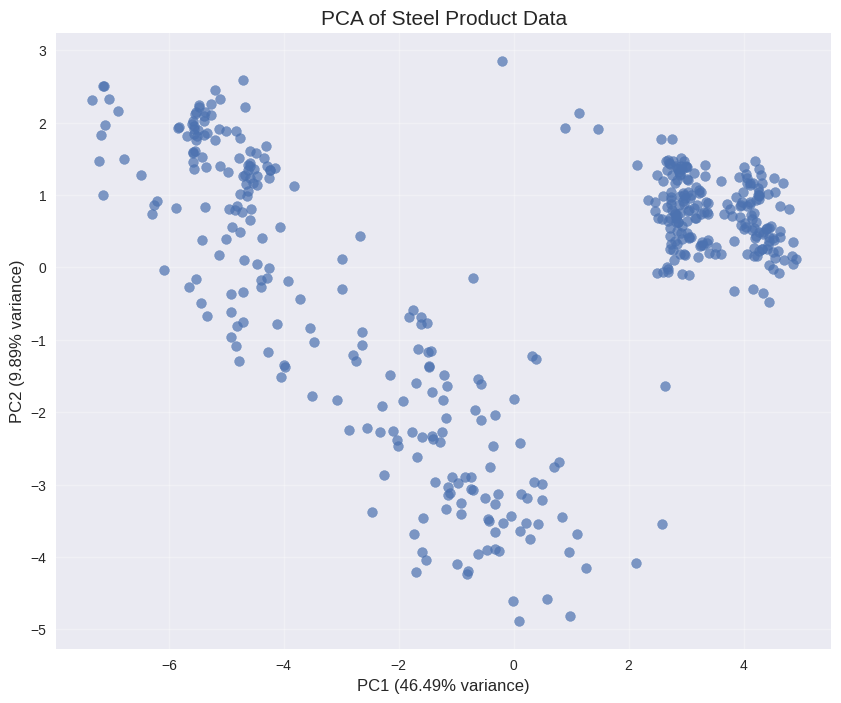

In [10]:
def apply_pca(X_scaled, n_components=2):
    """Apply PCA for dimensionality reduction and visualization"""
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

    return pca, X_pca

# Apply PCA for visualization
pca, X_pca = apply_pca(X_scaled)

# Plot PCA results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, s=50)
plt.title('PCA of Steel Product Data', fontsize=15)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('results/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

PCA transforms our high-dimensional product data (31 features) into a lower-dimensional space for two main purposes:
- Visualizing cluster separation that would be impossible in 31 dimensions
- Identifying the primary patterns of variation across products to understand what drives cluster formation.

=> PCA results show that the first principal component (PC1) explains 46.49% of the total variance in our 31-dimensional data, while PC2 explains an additional 9.89%. Together, these two components capture 56.38% of all information in our dataset, indicating strong patterns in steel product characteristics.

DETERMINING OPTIMAL NUMBER OF CLUSTERS

K=2: inertia=8198.24, silhouette score=0.3702, Davies-Bouldin=1.1682, Calinski-Harabasz=276.13
K=3: inertia=6434.40, silhouette score=0.3752, Davies-Bouldin=1.4447, Calinski-Harabasz=235.96
K=4: inertia=5974.82, silhouette score=0.2477, Davies-Bouldin=1.5534, Calinski-Harabasz=180.31
K=5: inertia=5513.35, silhouette score=0.2521, Davies-Bouldin=1.7683, Calinski-Harabasz=155.40
K=6: inertia=5179.08, silhouette score=0.2125, Davies-Bouldin=1.8492, Calinski-Harabasz=137.70
K=7: inertia=4832.15, silhouette score=0.2191, Davies-Bouldin=1.7552, Calinski-Harabasz=127.93
K=8: inertia=4464.19, silhouette score=0.2306, Davies-Bouldin=1.5367, Calinski-Harabasz=123.56
K=9: inertia=4192.51, silhouette score=0.2376, Davies-Bouldin=1.4841, Calinski-Harabasz=118.38
K=10: inertia=4066.39, silhouette score=0.2359, Davies-Bouldin=1.4799, Calinski-Harabasz=109.74


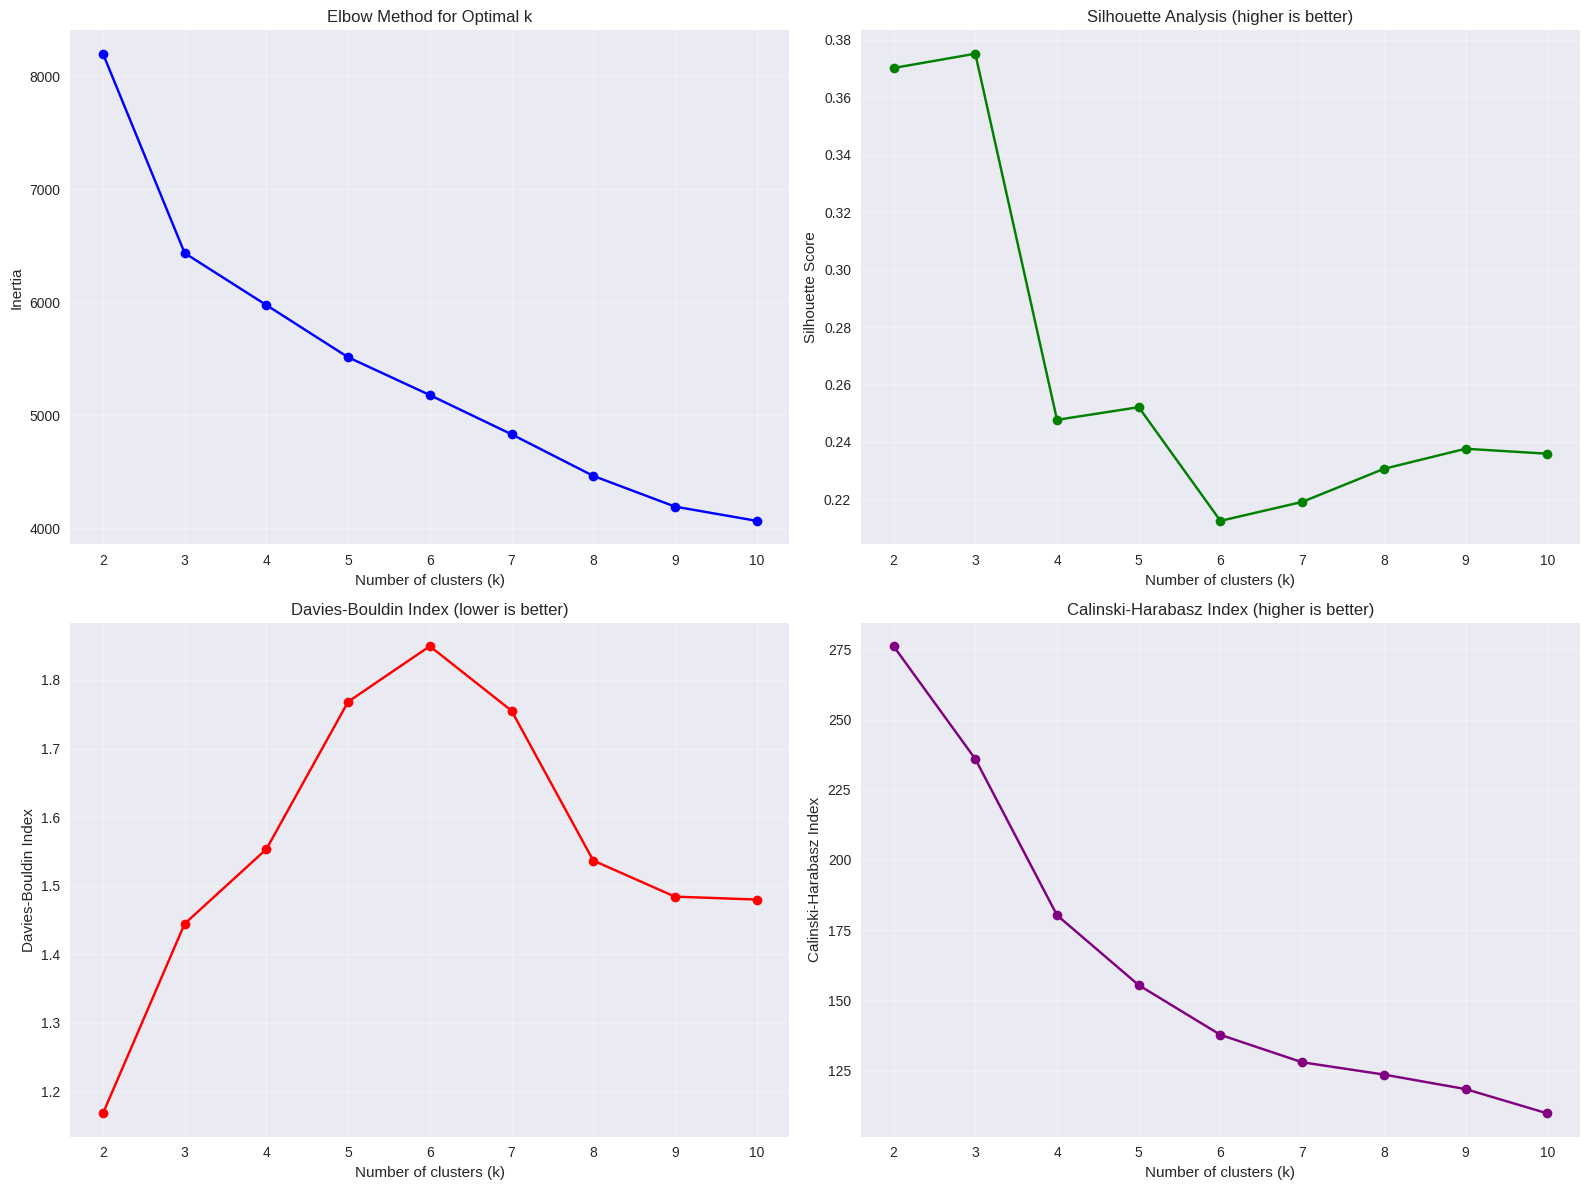


Optimal number of clusters based on silhouette score: 3
Optimal number of clusters based on Davies-Bouldin index: 2
Optimal number of clusters based on Calinski-Harabasz index: 2

Recommended number of clusters: 2 (supported by 2 metrics)


In [11]:
def determine_optimal_clusters(X_scaled, max_clusters=10):
    """Determine optimal number of clusters using multiple methods"""
    # Calculate metrics for different number of clusters
    k_range = range(2, max_clusters + 1)
    inertia = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []

    for k in k_range:
        # Apply K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)

        # Calculate metrics
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(X_scaled, cluster_labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))

        print(f"K={k}: inertia={kmeans.inertia_:.2f}, "
              f"silhouette score={silhouette_scores[-1]:.4f}, "
              f"Davies-Bouldin={davies_bouldin_scores[-1]:.4f}, "
              f"Calinski-Harabasz={calinski_harabasz_scores[-1]:.2f}")

    # Create a comprehensive plot of all metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Elbow method (inertia)
    axes[0, 0].plot(k_range, inertia, 'o-', color='blue')
    axes[0, 0].set_xlabel('Number of clusters (k)')
    axes[0, 0].set_ylabel('Inertia')
    axes[0, 0].set_title('Elbow Method for Optimal k')
    axes[0, 0].grid(True, alpha=0.3)

    # Silhouette score
    axes[0, 1].plot(k_range, silhouette_scores, 'o-', color='green')
    axes[0, 1].set_xlabel('Number of clusters (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Analysis (higher is better)')
    axes[0, 1].grid(True, alpha=0.3)

    # Davies-Bouldin index
    axes[1, 0].plot(k_range, davies_bouldin_scores, 'o-', color='red')
    axes[1, 0].set_xlabel('Number of clusters (k)')
    axes[1, 0].set_ylabel('Davies-Bouldin Index')
    axes[1, 0].set_title('Davies-Bouldin Index (lower is better)')
    axes[1, 0].grid(True, alpha=0.3)

    # Calinski-Harabasz index
    axes[1, 1].plot(k_range, calinski_harabasz_scores, 'o-', color='purple')
    axes[1, 1].set_xlabel('Number of clusters (k)')
    axes[1, 1].set_ylabel('Calinski-Harabasz Index')
    axes[1, 1].set_title('Calinski-Harabasz Index (higher is better)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/optimal_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Find optimal k based on different metrics
    optimal_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]
    optimal_k_davies = k_range[davies_bouldin_scores.index(min(davies_bouldin_scores))]
    optimal_k_calinski = k_range[calinski_harabasz_scores.index(max(calinski_harabasz_scores))]

    print(f"\nOptimal number of clusters based on silhouette score: {optimal_k_silhouette}")
    print(f"Optimal number of clusters based on Davies-Bouldin index: {optimal_k_davies}")
    print(f"Optimal number of clusters based on Calinski-Harabasz index: {optimal_k_calinski}")

    # Count frequency of each k
    k_counts = {k: 0 for k in k_range}
    k_counts[optimal_k_silhouette] += 1
    k_counts[optimal_k_davies] += 1
    k_counts[optimal_k_calinski] += 1

    # Find the most frequent k
    recommended_k = max(k_counts, key=k_counts.get)

    if k_counts[recommended_k] > 1:
        print(f"\nRecommended number of clusters: {recommended_k} (supported by {k_counts[recommended_k]} metrics)")
    else:
        # If there's a tie, prefer silhouette score
        print(f"\nRecommended number of clusters: {optimal_k_silhouette} (based on silhouette score)")
        recommended_k = optimal_k_silhouette

    # Save the metrics for later use
    metrics = {
        'k_range': list(k_range),
        'inertia': inertia,
        'silhouette_scores': silhouette_scores,
        'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores,
        'optimal_k': recommended_k
    }

    # Save metrics to a file
    np.save('results/cluster_metrics.npy', metrics)

    return recommended_k, metrics

# Determine optimal number of clusters
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS\n")
optimal_k, metrics = determine_optimal_clusters(X_scaled)

Use of several complementary methods to determine the optimal number of clusters:

- Elbow Method: Shows where adding more clusters stops providing significant reduction in inertia (within-cluster sum of squares).

- Silhouette Score: Measures how similar objects are to their own cluster compared to other clusters. Higher values indicate better separation.

- Davies-Bouldin Index: Evaluates average similarity between clusters. Lower values indicate better cluster separation.

- Calinski-Harabasz Index: Also known as the Variance Ratio Criterion, measures the ratio of between-cluster dispersion to within-cluster dispersion.

**Final choice :**

The metrics show a split recommendation:

- Two metrics (Davies-Bouldin and Calinski-Harabasz) favor k=2
- One metric (Silhouette) strongly favors k=3
- The Elbow method is less decisive but suggests k=2 or k=3

We will choose k=2 because:

- Majority vote: Two of three quantitative metrics (Davies-Bouldin and Calinski-Harabasz) support k=2
- Parsimony principle: When in doubt, the simpler model (fewer clusters) is often preferred
- Clear separation: The Davies-Bouldin score shows better separation with 2 clusters


# 2. K-means Clustering Implementation


In [15]:
def apply_kmeans(X_scaled, n_clusters, random_state=42):
    """Apply K-means clustering"""
    print("\nApplying K-means clustering...")

    # Train the model
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    # Calculate silhouette score
    silhouette = silhouette_score(X_scaled, labels)

    print(f"K-means with {n_clusters} clusters complete")
    print(f"Silhouette score: {silhouette:.4f}")

    # Create result dictionary
    result = {
        'model': kmeans,
        'labels': labels,
        'silhouette': silhouette,
        'n_clusters': n_clusters
    }

    # Create directory if it doesn't exist
    os.makedirs('results/kmeans', exist_ok=True)
    # Save the cluster labels
    np.save(f'results/kmeans/kmeans_labels_{n_clusters}.npy', labels)

    return result

# Apply K-means clustering
kmeans_result = apply_kmeans(X_scaled, optimal_k)


Applying K-means clustering...
K-means with 2 clusters complete
Silhouette score: 0.3702


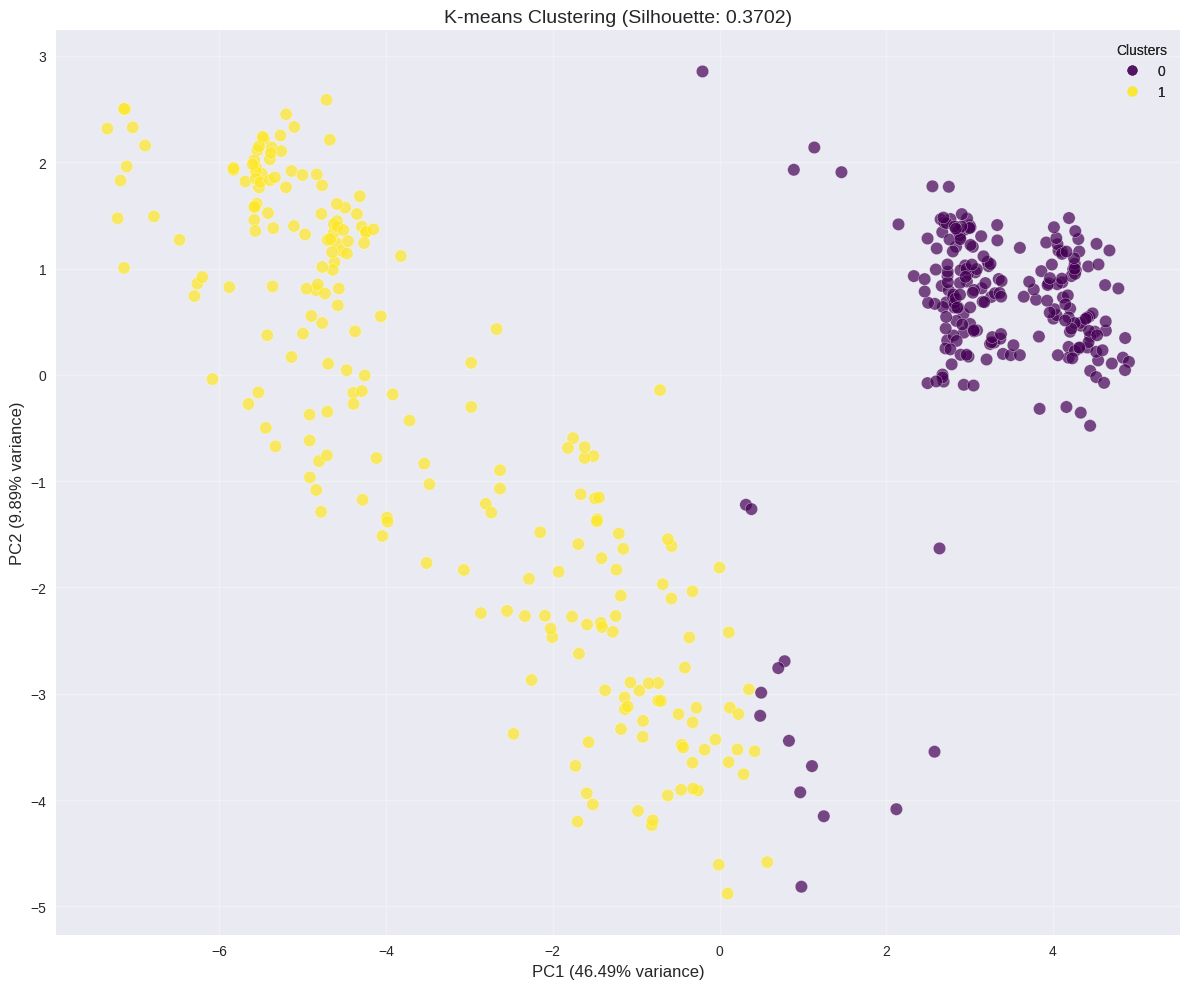


Cluster Centers (Original Scale):


,mean,std,min,max,range,high_state_mean,low_state_mean,high_state_ratio,high_state_std,low_state_std,transition_point,transition_magnitude,trend_slope,EPAI_COILC,LARGCOILVISC,Aluminium,Azote,Bore,Carbone,Chrome,Cuivre,Etain,Manganese,Molybdene,Nickel,Niobium,Phosphore,Silicium,Soufre,Titane
0,223.110,457.770,-458.530,706.040,1164.560,526.800,-365.910,0.660,190.060,138.680,0.650,108.630,-4.640,3.600,1309.500,359.900,50.340,27.950,2109.040,1597.240,122.320,42.830,11362.440,20.480,135.110,13.130,116.990,2398.600,14.000,354.250
1,143.110,328.780,-267.620,644.720,912.340,388.560,-232.620,0.600,154.430,61.180,0.590,83.190,-3.350,2.670,1249.430,391.900,37.410,9.840,365.090,332.370,173.010,33.620,2626.470,13.000,133.420,7.130,117.140,66.300,94.070,86.240


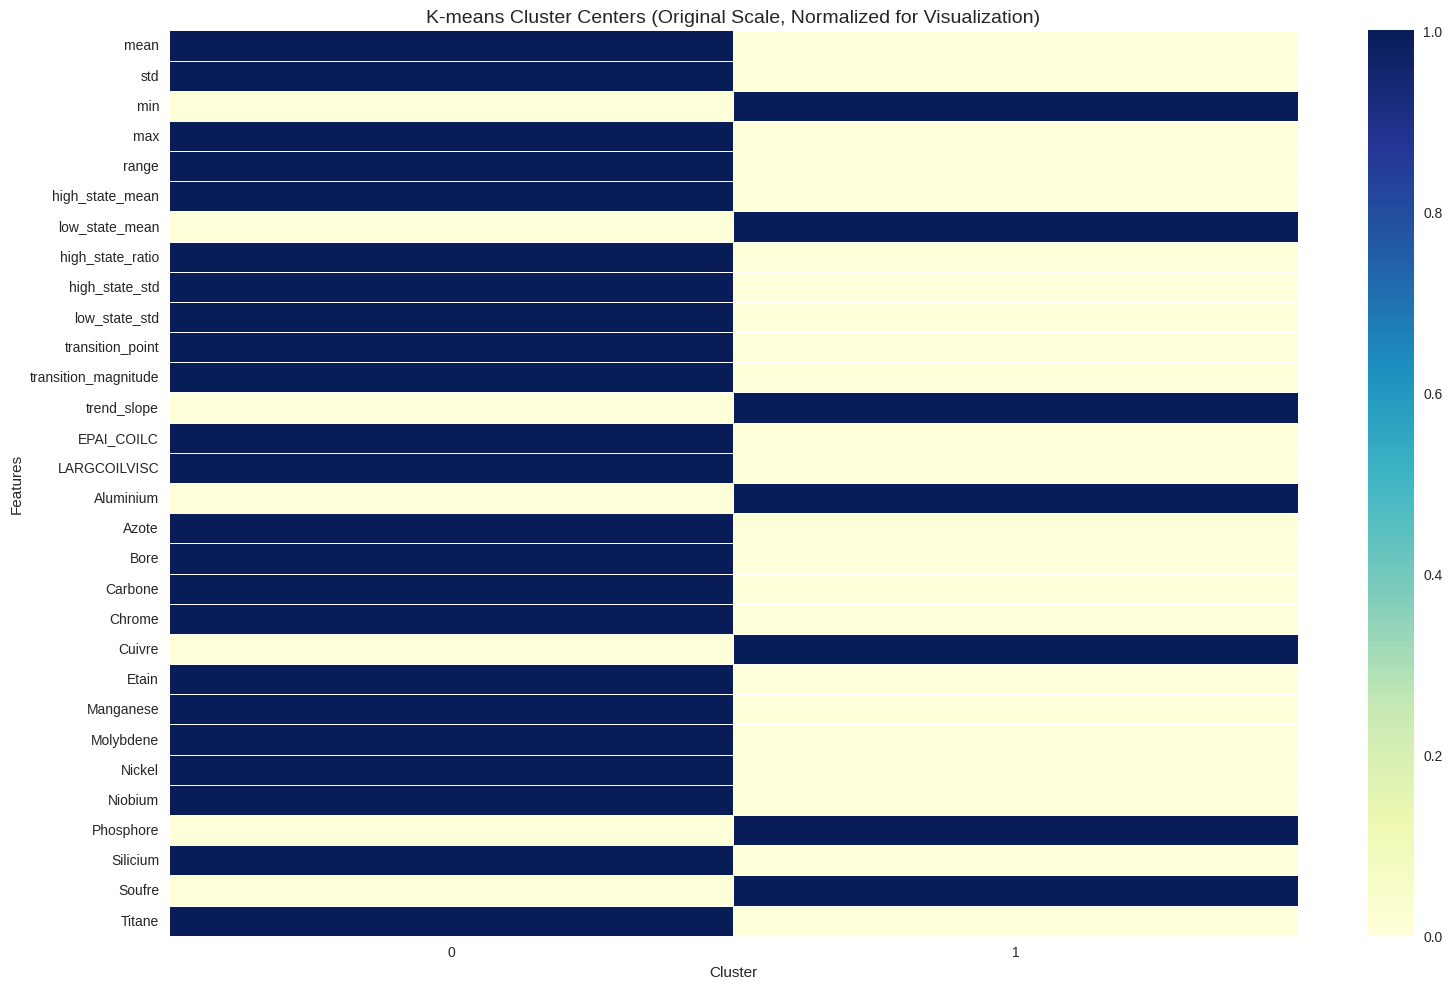


Cluster Centers (Standardized Scale):


,mean,std,min,max,range,high_state_mean,low_state_mean,high_state_ratio,high_state_std,low_state_std,transition_point,transition_magnitude,trend_slope,EPAI_COILC,LARGCOILVISC,Aluminium,Azote,Bore,Carbone,Chrome,Cuivre,Etain,Manganese,Molybdene,Nickel,Niobium,Phosphore,Silicium,Soufre,Titane
0,0.720,0.770,-0.770,0.530,0.740,0.760,-0.740,0.670,0.630,0.730,0.210,0.290,-0.770,0.580,0.110,-0.130,0.410,0.600,0.890,0.910,-0.350,0.150,0.910,0.320,0.030,0.060,-0.000,0.930,-0.760,0.650
1,-0.740,-0.790,0.790,-0.540,-0.760,-0.780,0.760,-0.690,-0.650,-0.750,-0.220,-0.290,0.790,-0.600,-0.110,0.130,-0.420,-0.620,-0.920,-0.940,0.360,-0.160,-0.940,-0.330,-0.040,-0.060,0.000,-0.960,0.780,-0.670


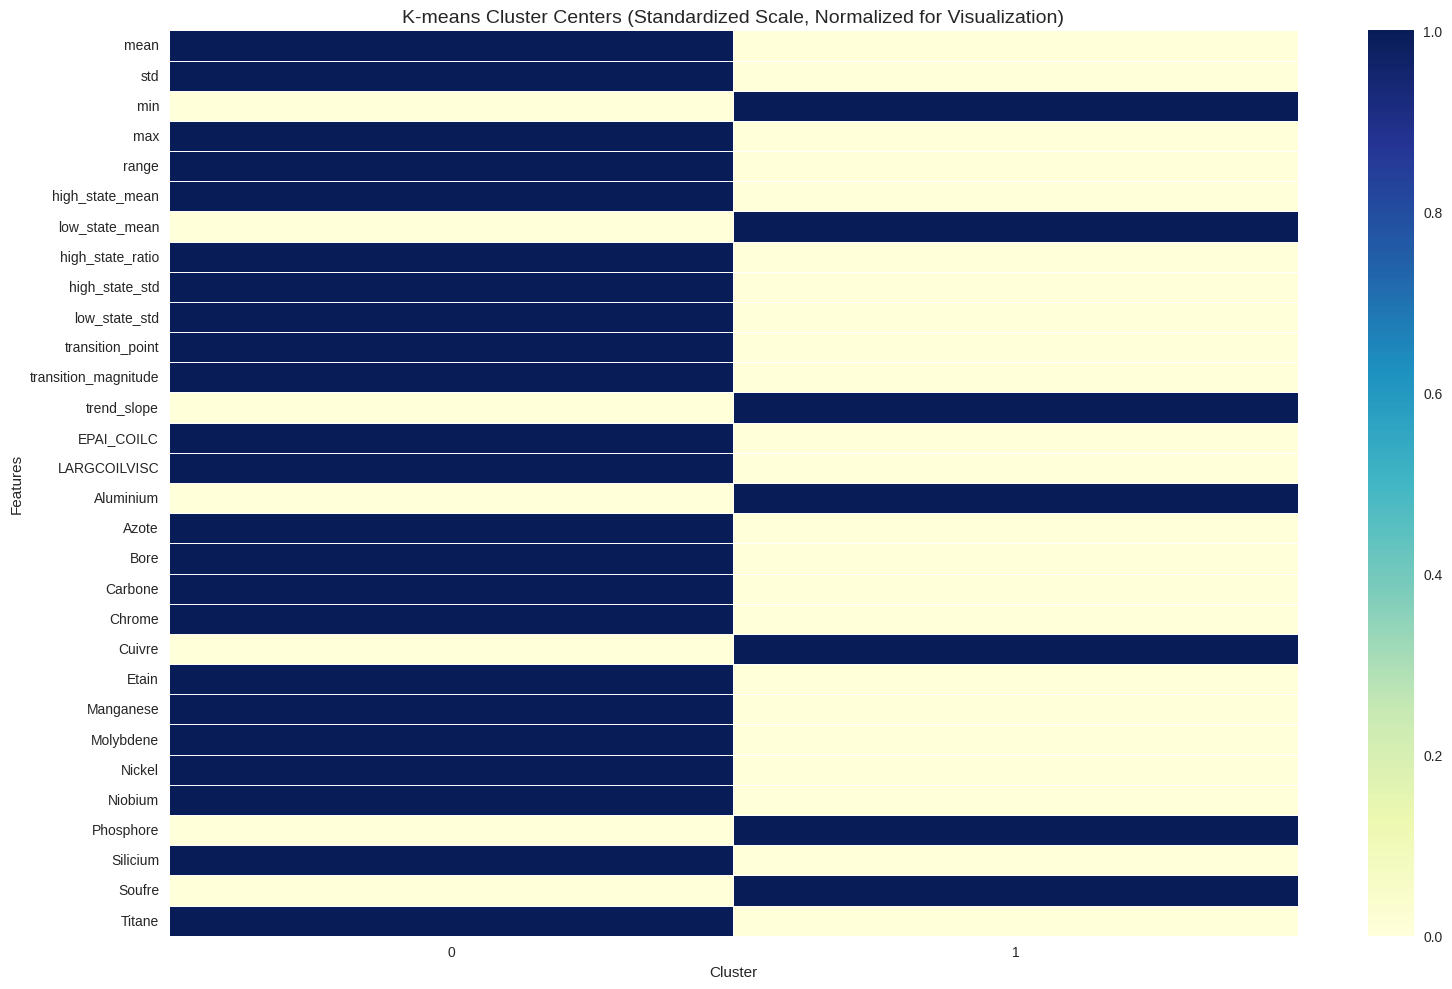

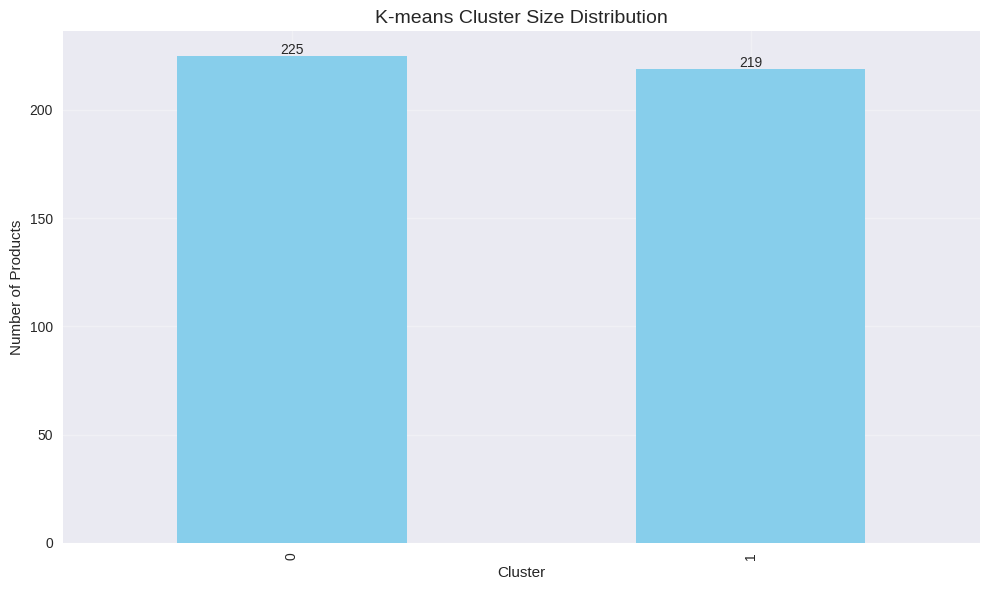

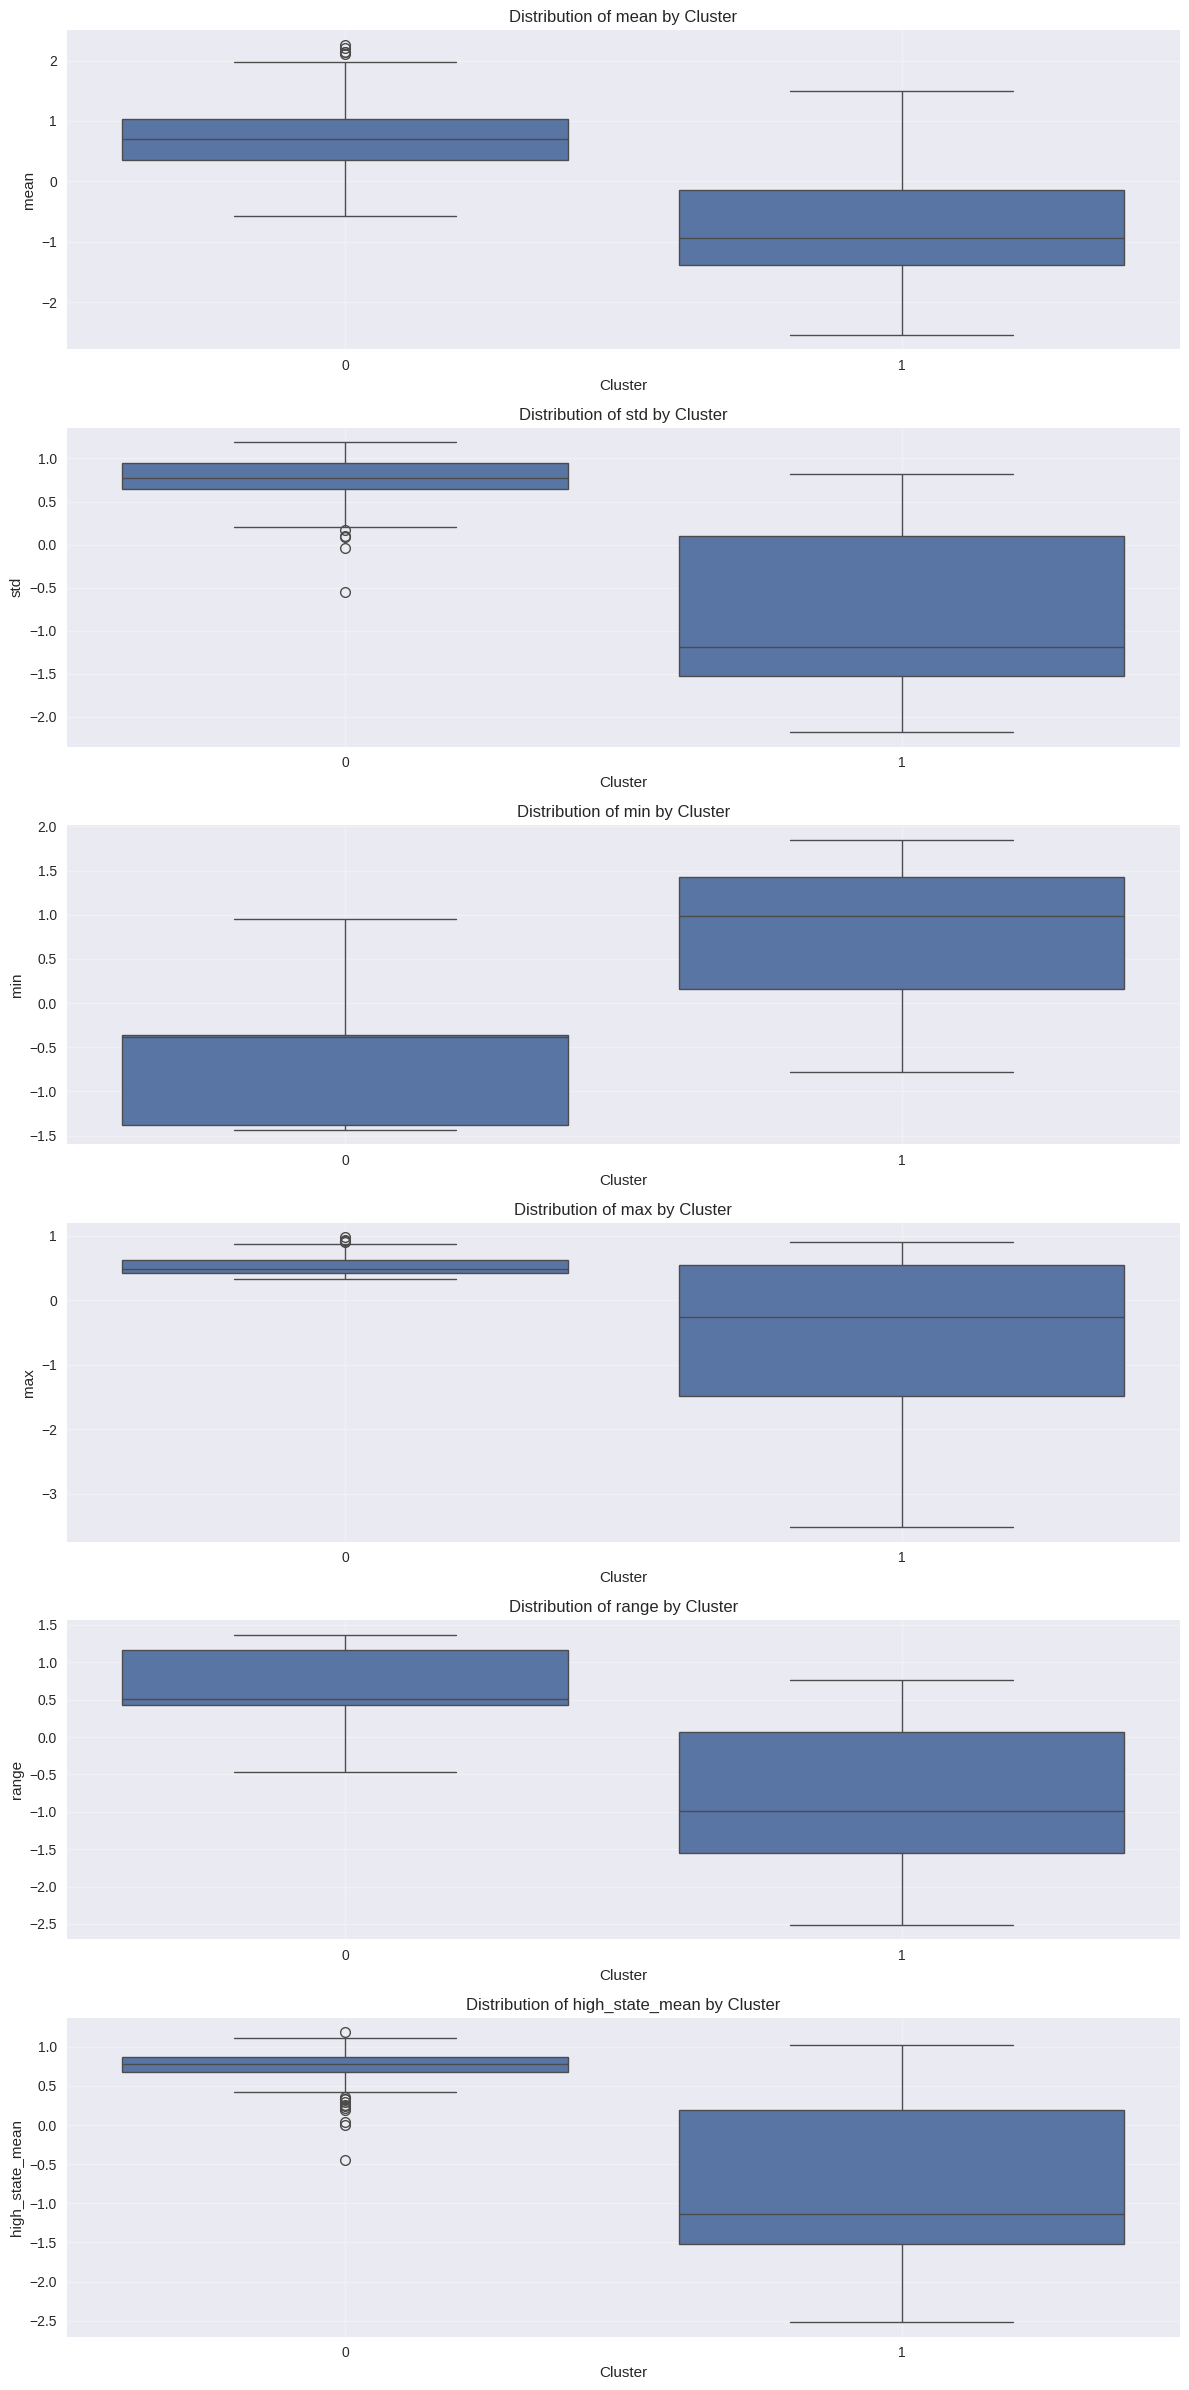

In [16]:
def visualize_kmeans(X_scaled, kmeans_result, selected_features, scaler=None, title_prefix="K-means"):
    """Visualize K-means clustering results"""
    labels = kmeans_result['labels']

    # 1. PCA Visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(
        data=X_pca,
        columns=['PC1', 'PC2']
    )
    pca_df['cluster'] = labels

    # Plot PCA
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        pca_df['PC1'],
        pca_df['PC2'],
        c=pca_df['cluster'],
        cmap='viridis',
        s=80,
        alpha=0.7,
        edgecolor='w'
    )

    # Add legend
    legend1 = plt.legend(*scatter.legend_elements(),
                         title="Clusters",
                         loc="upper right")
    plt.gca().add_artist(legend1)

    # Create directory if it doesn't exist
    os.makedirs('results/kmeans', exist_ok=True)
    # Add titles and labels
    plt.title(f'{title_prefix} Clustering (Silhouette: {kmeans_result["silhouette"]:.4f})', fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/kmeans/kmeans_pca_{kmeans_result["n_clusters"]}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Cluster Centers Analysis
    centers = kmeans_result['model'].cluster_centers_

    # Create a dataframe of cluster centers
    centers_df = pd.DataFrame(centers, columns=selected_features)

    # Transform centers to original scale if a scaler is provided
    if scaler is not None:
        # Use the inverse_transform method of the scaler
        centers_original = scaler.inverse_transform(centers)
        centers_df_original = pd.DataFrame(centers_original, columns=selected_features)

        # Display both scaled and original centers
        print("\nCluster Centers (Original Scale):")
        display(centers_df_original.round(2))

        # Create and show heatmap for original scale centers
        plt.figure(figsize=(16, 10))
        # Normalize for visualization purposes
        centers_original_scaled = (centers_df_original - centers_df_original.min()) / (centers_df_original.max() - centers_df_original.min())
        sns.heatmap(
            centers_original_scaled.T,
            annot=False,
            cmap="YlGnBu",
            linewidths=0.5
        )
        plt.title(f'{title_prefix} Cluster Centers (Original Scale, Normalized for Visualization)', fontsize=14)
        plt.ylabel('Features')
        plt.xlabel('Cluster')
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(f'results/kmeans/kmeans_centers_original_{kmeans_result["n_clusters"]}.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Scale the centers for better visualization (standardized centers)
    print("\nCluster Centers (Standardized Scale):")
    display(centers_df.round(2))

    centers_scaled = (centers_df - centers_df.min()) / (centers_df.max() - centers_df.min())

    # Heatmap of cluster centers (standardized)
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        centers_scaled.T,
        annot=False,
        cmap="YlGnBu",
        linewidths=0.5
    )
    plt.title(f'{title_prefix} Cluster Centers (Standardized Scale, Normalized for Visualization)', fontsize=14)
    plt.ylabel('Features')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'results/kmeans/kmeans_centers_standardized_{kmeans_result["n_clusters"]}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Cluster Size Distribution
    plt.figure(figsize=(10, 6))
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    cluster_counts.plot(kind='bar', color='skyblue')
    plt.title(f'{title_prefix} Cluster Size Distribution', fontsize=14)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Products')
    plt.grid(True, alpha=0.3)

    # Add count labels
    for i, count in enumerate(cluster_counts):
        plt.text(i, count + 1, str(count), ha='center')

    plt.tight_layout()
    plt.savefig(f'results/kmeans/kmeans_distribution_{kmeans_result["n_clusters"]}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Feature distributions within clusters
    # Show boxplots for a subset of important features
    important_features = selected_features[:min(6, len(selected_features))]  # First 6 features or less

    # Create a figure with a subplot for each important feature
    fig, axes = plt.subplots(len(important_features), 1, figsize=(12, 4*len(important_features)))

    # Create a DataFrame with scaled data
    X_df = pd.DataFrame(X_scaled, columns=selected_features)
    X_df['cluster'] = labels

    # Plot boxplots for each feature
    for i, feature in enumerate(important_features):
        sns.boxplot(x='cluster', y=feature, data=X_df, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'results/kmeans/kmeans_features_{kmeans_result["n_clusters"]}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save cluster information
    cluster_info = {
        'centers': centers,
        'centers_original': centers_original if scaler is not None else None,
        'cluster_counts': cluster_counts.to_dict()
    }
    np.save(f'results/kmeans/kmeans_info_{kmeans_result["n_clusters"]}.npy', cluster_info)

    return pca, X_pca

# Visualize K-means results
pca_kmeans, X_pca_kmeans = visualize_kmeans(X_scaled, kmeans_result, selected_features, scaler)

The K-means clustering has identified two distinct groups of steel products
- Cluster 0 (225 products): Characterized by higher sensor readings (mean, std, max, range), higher high-state metrics, and lower minimum values. These products show consistent chemical compositions with higher levels of most elements except for specific ones like Aluminum, Copper, and Phosphore.
- Cluster 1 (219 products): Distinguished by significantly different sensor behavior, lower readings overall but higher minimum values, more negative trend slope, and distinct chemical composition (higher Aluminum, Copper, Phosphore, Soufre).

# 3. Gaussian Mixture Model (GMM) Implementation

In [18]:
def apply_gmm(X_scaled, n_clusters, random_state=42, covariance_type='full'):
    """Apply Gaussian Mixture Model clustering"""
    print("\nApplying Gaussian Mixture Model clustering...")

    # Train the model
    gmm = GaussianMixture(n_components=n_clusters, random_state=random_state, covariance_type=covariance_type)
    labels = gmm.fit_predict(X_scaled)

    # Calculate silhouette score
    silhouette = silhouette_score(X_scaled, labels)

    print(f"GMM with {n_clusters} clusters complete")
    print(f"Silhouette score: {silhouette:.4f}")

    # Create result dictionary
    result = {
        'model': gmm,
        'labels': labels,
        'silhouette': silhouette,
        'n_clusters': n_clusters,
        'covariance_type': covariance_type
    }
    # Create directory if it doesn't exist
    os.makedirs('results/gmm', exist_ok=True)
    # Save the cluster labels
    np.save(f'results/gmm/gmm_labels_{n_clusters}_{covariance_type}.npy', labels)

    return result

# Find the optimal covariance type for GMM
def select_best_covariance_type(X_scaled, n_components):
    """Select the best covariance type for GMM"""
    cov_types = ['full', 'tied', 'diag', 'spherical']
    results = {}

    for cov_type in cov_types:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
        labels = gmm.fit_predict(X_scaled)
        silhouette = silhouette_score(X_scaled, labels)
        results[cov_type] = silhouette
        print(f"GMM with {cov_type} covariance: Silhouette score = {silhouette:.4f}")

    best_cov_type = max(results, key=results.get)
    print(f"\nBest covariance type: {best_cov_type} (Silhouette: {results[best_cov_type]:.4f})")

    return best_cov_type

# Select best covariance type for GMM
best_cov_type = select_best_covariance_type(X_scaled, optimal_k)

# Apply GMM with optimal covariance type
gmm_result = apply_gmm(X_scaled, optimal_k, covariance_type=best_cov_type)

GMM with full covariance: Silhouette score = 0.3693
GMM with tied covariance: Silhouette score = 0.3696
GMM with diag covariance: Silhouette score = 0.3682
GMM with spherical covariance: Silhouette score = 0.3663

Best covariance type: tied (Silhouette: 0.3696)

Applying Gaussian Mixture Model clustering...
GMM with 2 clusters complete
Silhouette score: 0.3696


Covariance Type Selection for GMM :

We tested four covariance types **(full, tied, diagonal, spherical)** to determine the optimal structure
The "tied" covariance performed best (silhouette: 0.3696), indicating that the clusters share similar internal variability patterns while having different centers. This suggests the steel products in different clusters follow similar statistical distributions but with shifted means, likely corresponding to similar manufacturing processes with different target specifications.

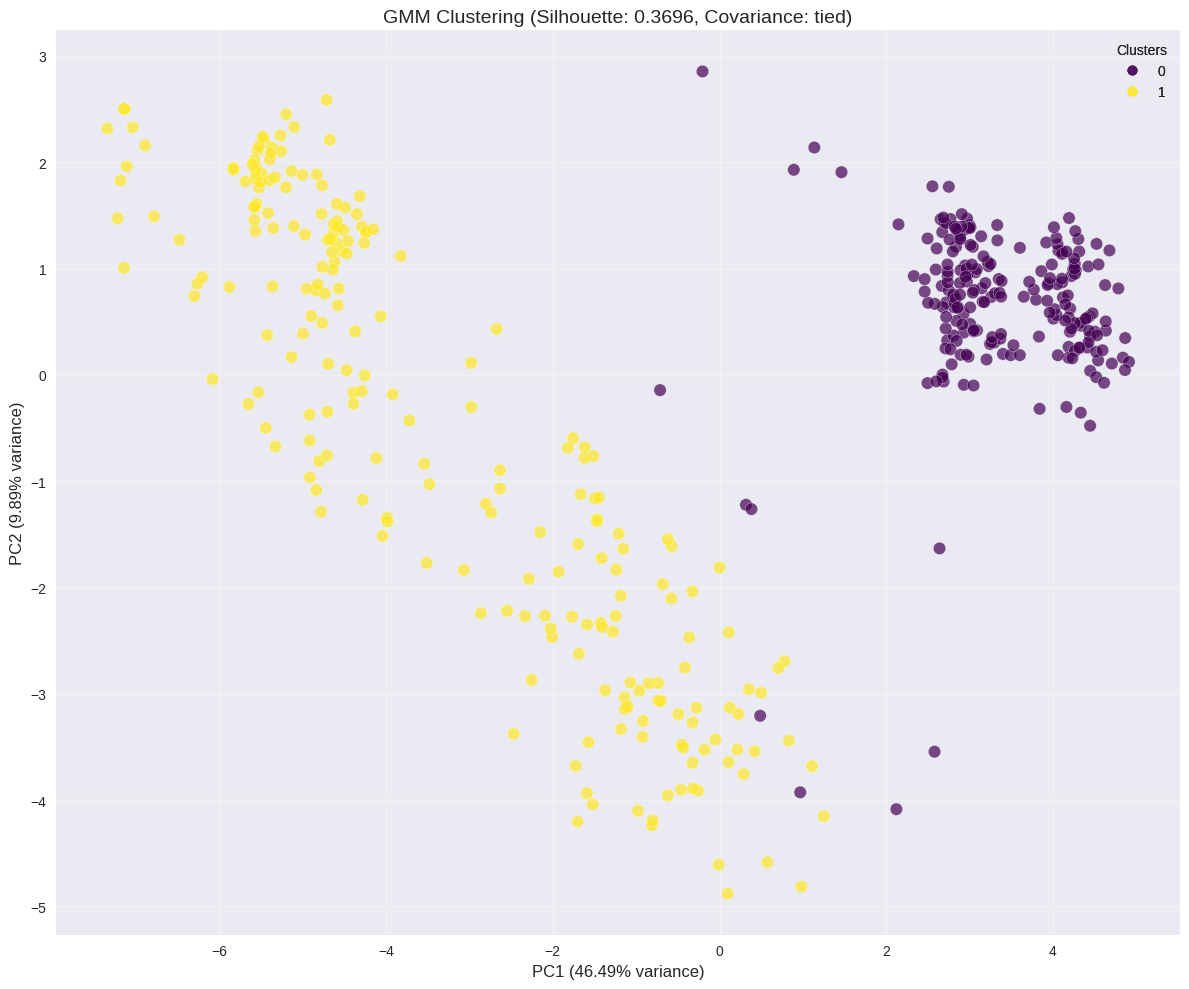


GMM Component Means:


,mean,std,min,max,range,high_state_mean,low_state_mean,high_state_ratio,high_state_std,low_state_std,transition_point,transition_magnitude,trend_slope,EPAI_COILC,LARGCOILVISC,Aluminium,Azote,Bore,Carbone,Chrome,Cuivre,Etain,Manganese,Molybdene,Nickel,Niobium,Phosphore,Silicium,Soufre,Titane
0,0.690,0.770,-0.780,0.520,0.750,0.750,-0.760,0.660,0.620,0.730,0.220,0.300,-0.770,0.520,0.090,-0.170,0.440,0.650,0.950,0.970,-0.370,0.150,0.970,0.380,0.050,0.050,-0.020,0.980,-0.790,0.640
1,-0.680,-0.750,0.760,-0.510,-0.730,-0.730,0.740,-0.650,-0.600,-0.710,-0.220,-0.290,0.750,-0.510,-0.080,0.170,-0.430,-0.630,-0.920,-0.940,0.360,-0.140,-0.940,-0.370,-0.040,-0.050,0.020,-0.960,0.770,-0.620


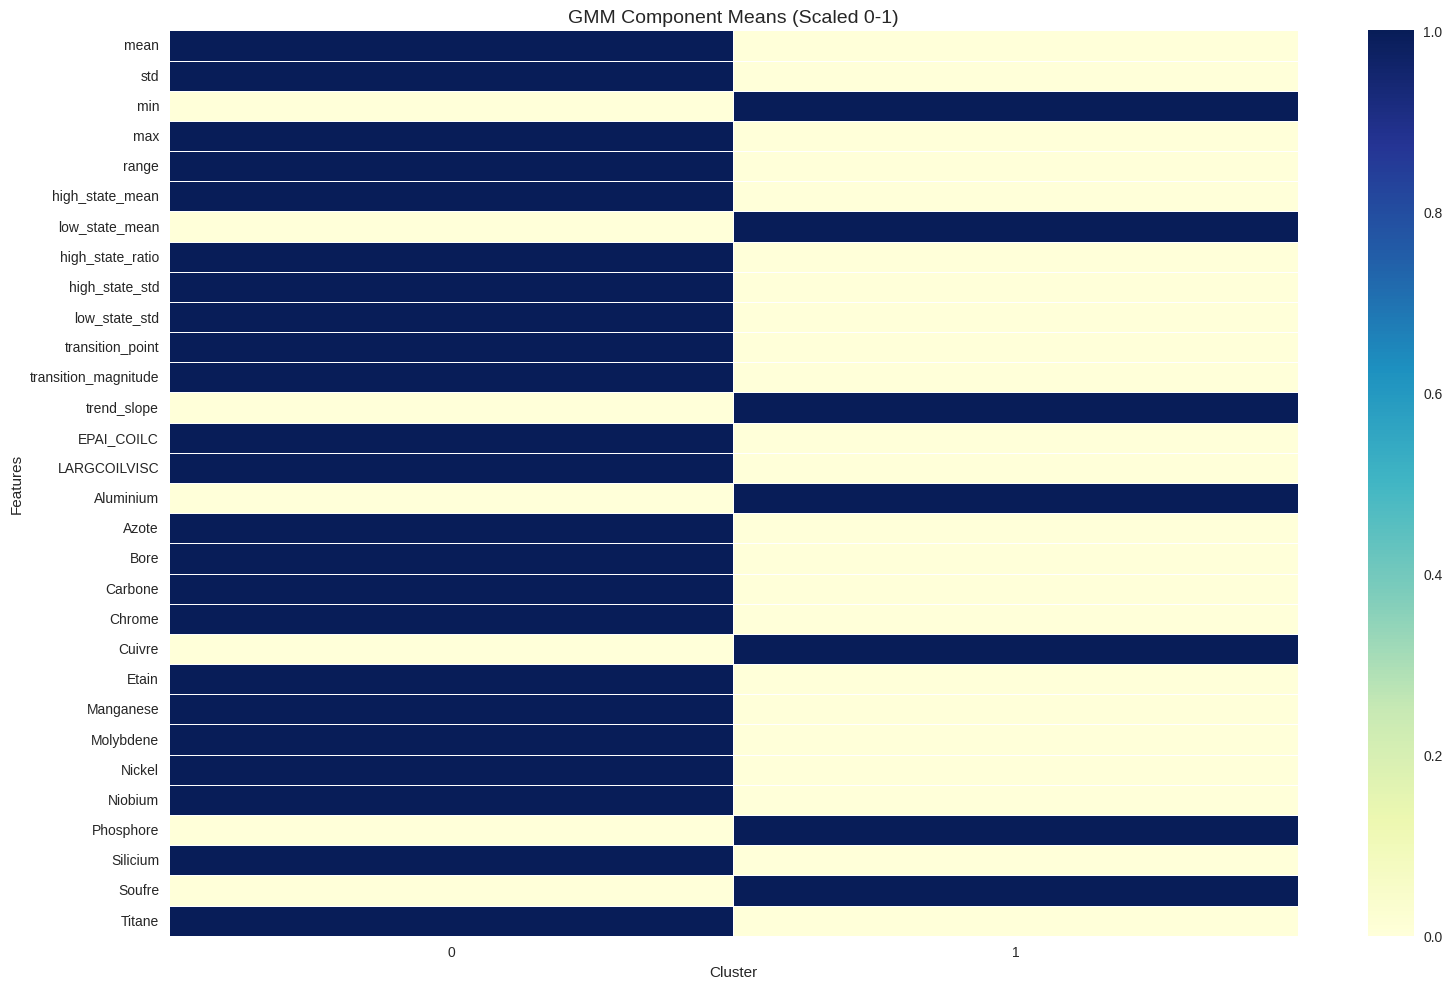

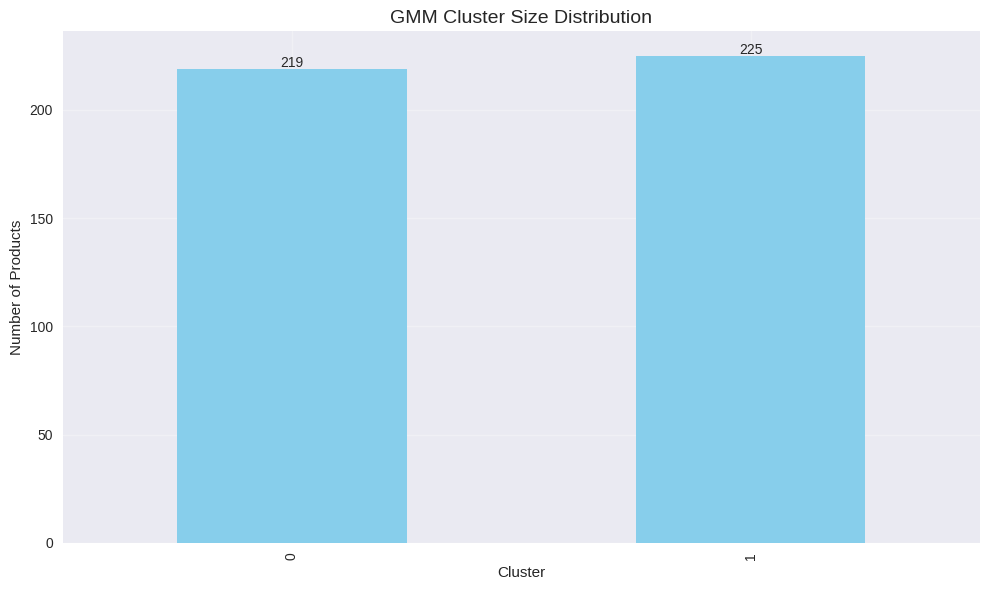

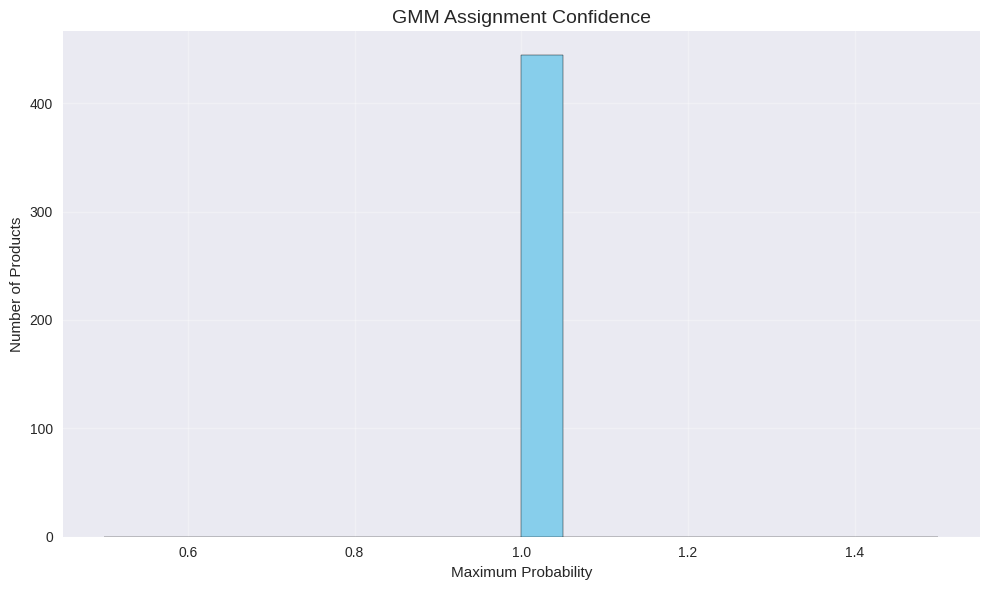

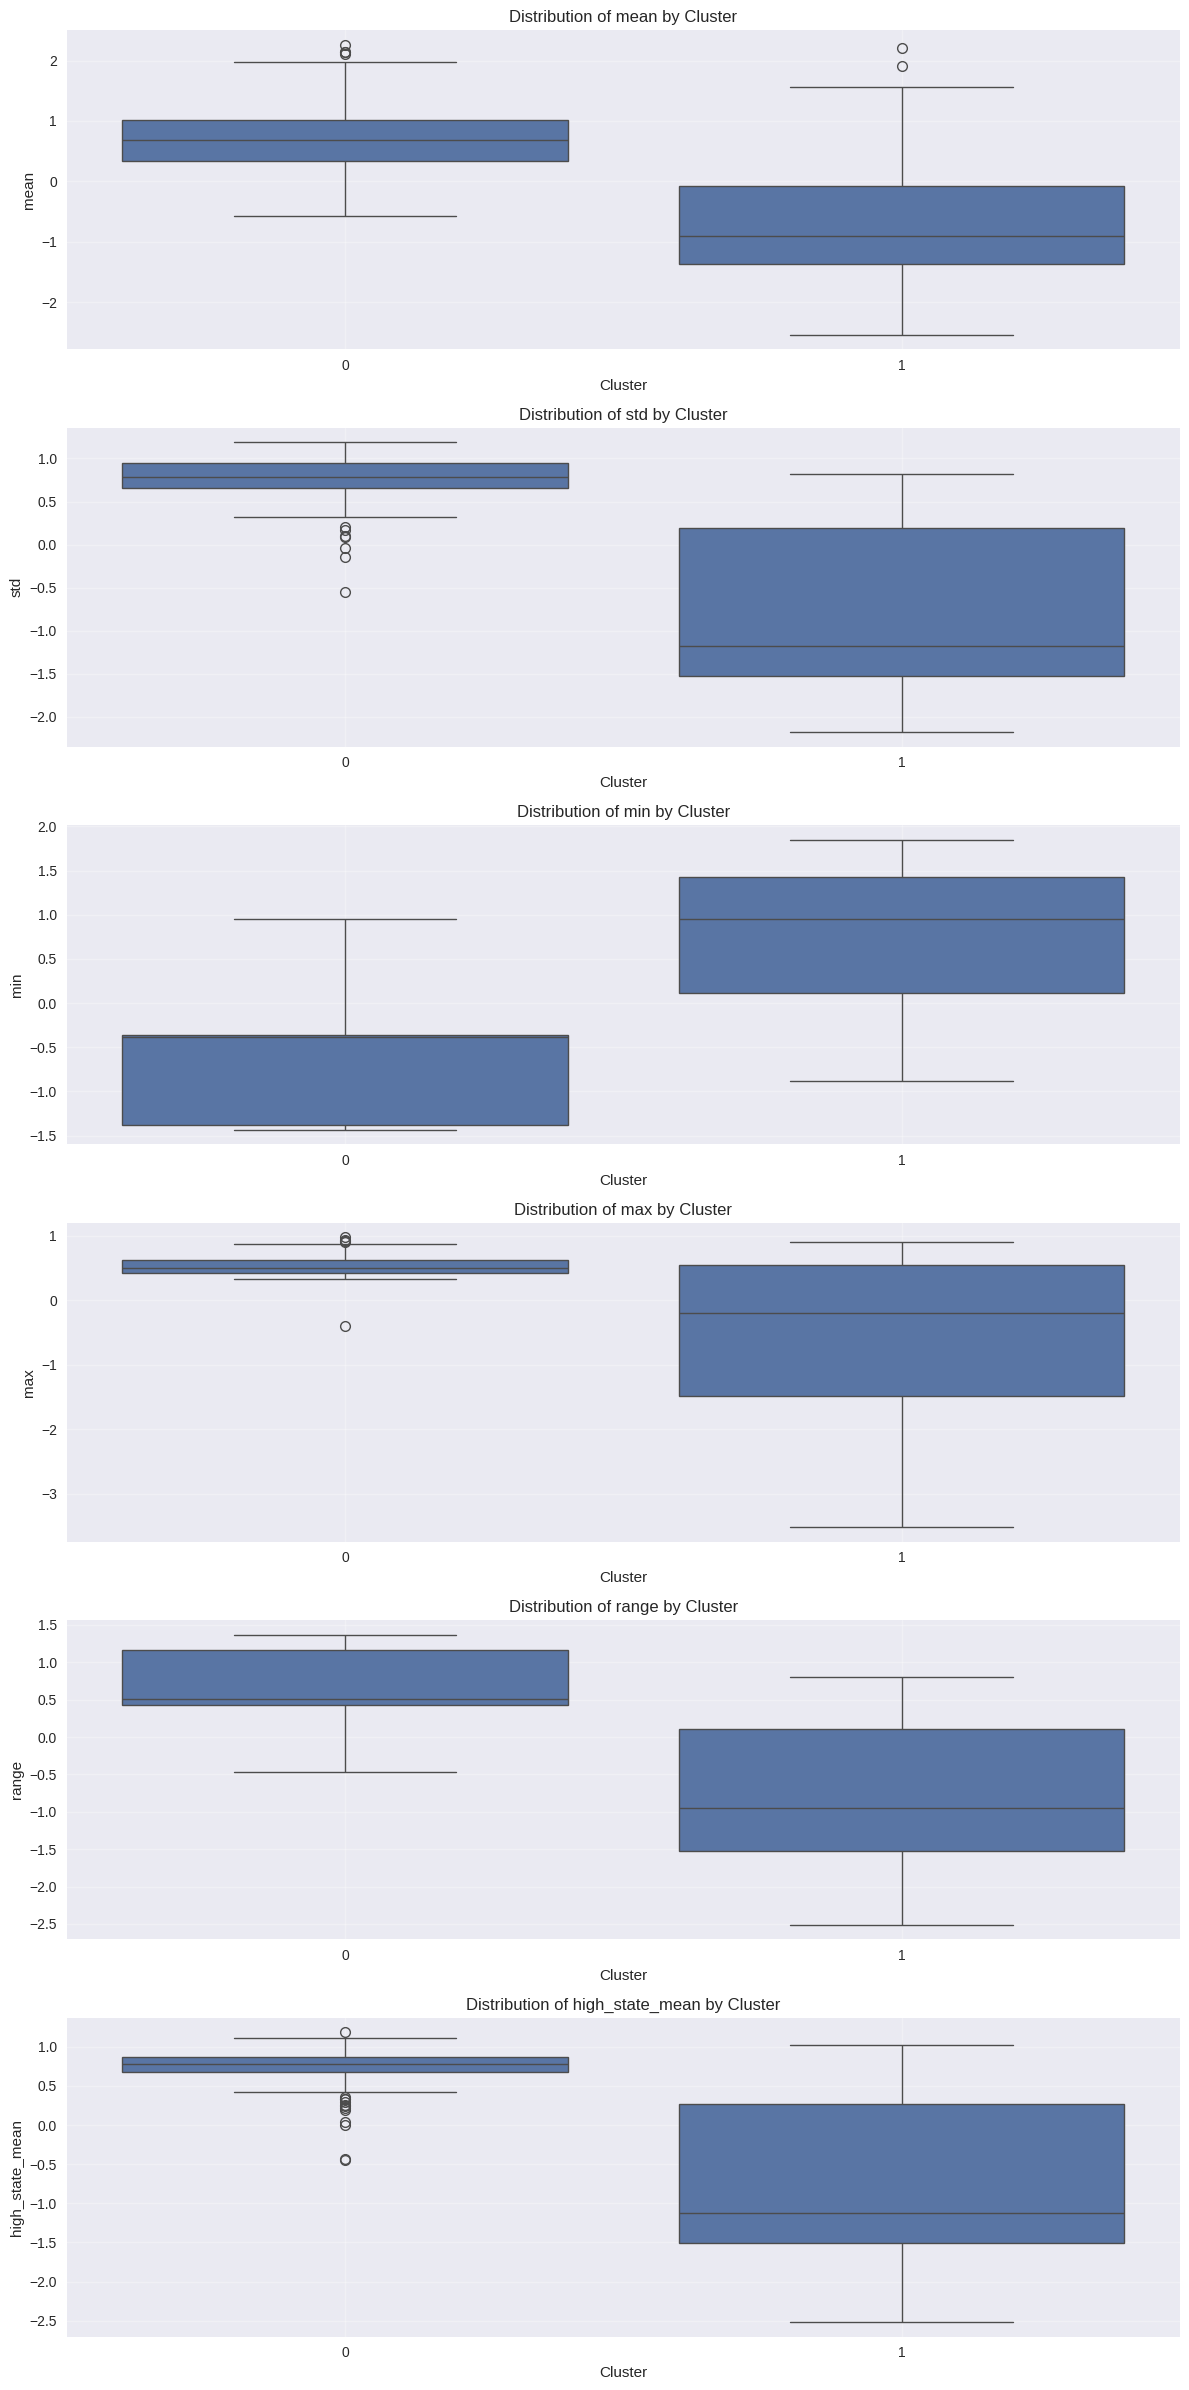

In [19]:
def visualize_gmm(X_scaled, gmm_result, selected_features, title_prefix="GMM"):
    """Visualize Gaussian Mixture Model clustering results"""
    labels = gmm_result['labels']
    gmm_model = gmm_result['model']
    covariance_type = gmm_result['covariance_type']

    # 1. PCA Visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(
        data=X_pca,
        columns=['PC1', 'PC2']
    )
    pca_df['cluster'] = labels

    # Plot PCA
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        pca_df['PC1'],
        pca_df['PC2'],
        c=pca_df['cluster'],
        cmap='viridis',
        s=80,
        alpha=0.7,
        edgecolor='w'
    )

    # Add legend
    legend1 = plt.legend(*scatter.legend_elements(),
                         title="Clusters",
                         loc="upper right")
    plt.gca().add_artist(legend1)

    # Create directory if it doesn't exist
    os.makedirs('results/gmm', exist_ok=True)
    # Add titles and labels
    plt.title(f'{title_prefix} Clustering (Silhouette: {gmm_result["silhouette"]:.4f}, Covariance: {covariance_type})', fontsize=14)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/gmm/gmm_pca_{gmm_result["n_clusters"]}_{covariance_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Cluster Centers Analysis
    means = gmm_model.means_

    # Create a dataframe of cluster centers
    means_df = pd.DataFrame(means, columns=selected_features)

    # Display means
    print("\nGMM Component Means:")
    display(means_df.round(2))

    # Scale the means for better visualization
    means_scaled = (means_df - means_df.min()) / (means_df.max() - means_df.min())

    # Heatmap of cluster centers
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        means_scaled.T,
        annot=False,
        cmap="YlGnBu",
        linewidths=0.5
    )
    plt.title(f'{title_prefix} Component Means (Scaled 0-1)', fontsize=14)
    plt.ylabel('Features')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'results/gmm/gmm_means_{gmm_result["n_clusters"]}_{covariance_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Cluster Size Distribution
    plt.figure(figsize=(10, 6))
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    cluster_counts.plot(kind='bar', color='skyblue')
    plt.title(f'{title_prefix} Cluster Size Distribution', fontsize=14)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Products')
    plt.grid(True, alpha=0.3)

    # Add count labels
    for i, count in enumerate(cluster_counts):
        plt.text(i, count + 1, str(count), ha='center')

    plt.tight_layout()
    plt.savefig(f'results/gmm/gmm_distribution_{gmm_result["n_clusters"]}_{covariance_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Probability Analysis
    # We can visualize how confident GMM is about its assignments
    probabilities = gmm_model.predict_proba(X_scaled)

    # Check the maximum probability for each sample
    max_probs = np.max(probabilities, axis=1)

    plt.figure(figsize=(10, 6))
    plt.hist(max_probs, bins=20, color='skyblue', edgecolor='black')
    plt.title('GMM Assignment Confidence', fontsize=14)
    plt.xlabel('Maximum Probability')
    plt.ylabel('Number of Products')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/gmm/gmm_probabilities_{gmm_result["n_clusters"]}_{covariance_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Feature distributions within clusters
    # Show boxplots for a subset of important features
    important_features = selected_features[:min(6, len(selected_features))]  # First 6 features or less

    # Create a figure with a subplot for each important feature
    fig, axes = plt.subplots(len(important_features), 1, figsize=(12, 4*len(important_features)))

    # Create a DataFrame with scaled data
    X_df = pd.DataFrame(X_scaled, columns=selected_features)
    X_df['cluster'] = labels

    # Plot boxplots for each feature
    for i, feature in enumerate(important_features):
        sns.boxplot(x='cluster', y=feature, data=X_df, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'results/gmm/gmm_features_{gmm_result["n_clusters"]}_{covariance_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save cluster information
    cluster_info = {
        'means': means,
        'covariances': gmm_model.covariances_,
        'weights': gmm_model.weights_,
        'cluster_counts': cluster_counts.to_dict()
    }
    np.save(f'results/gmm/gmm_info_{gmm_result["n_clusters"]}_{covariance_type}.npy', cluster_info)

    return pca, X_pca

# Visualize GMM results
pca_gmm, X_pca_gmm = visualize_gmm(X_scaled, gmm_result, selected_features)

The GMM clustering shows:

Nearly all products show maximum probability at 1.0, indicating the GMM model is extremely confident about cluster assignments. This high certainty confirms the presence of two naturally distinct groups in the data.

- Cluster 0: Higher mean, std, max, range values; higher high-state metrics
- Cluster 1: Higher minimum values, trend slope, and specific chemical elements (Aluminum, Copper, Phosphore, Soufre)

# 4. DBSCAN  Clustering Implementation



Estimating optimal epsilon parameter for DBSCAN...


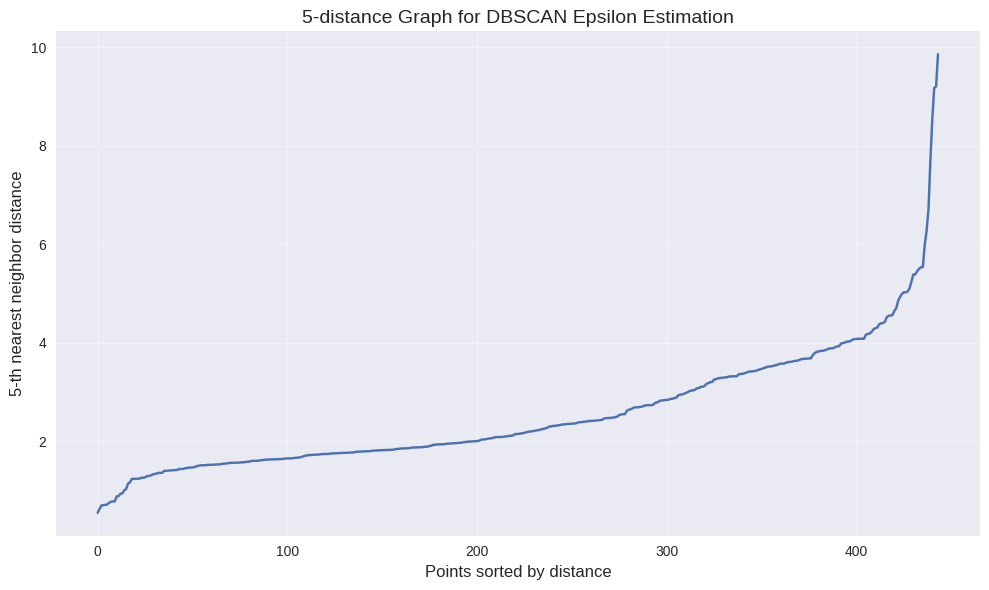

Estimated epsilon based on knee detection: 5.0381 at index 427


In [20]:
def estimate_dbscan_parameters(X_scaled, min_samples=5):
    """Estimate the optimal epsilon parameter for DBSCAN"""
    print("\nEstimating optimal epsilon parameter for DBSCAN...")

    # Compute k-distances (using k=min_samples)
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X_scaled)
    distances, indices = neigh.kneighbors(X_scaled)
    distances = np.sort(distances[:, -1])

    # Create directory if it doesn't exist
    os.makedirs('results/dbscan', exist_ok=True)
    # Plot k-distances
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f'{min_samples}-distance Graph for DBSCAN Epsilon Estimation', fontsize=14)
    plt.xlabel('Points sorted by distance', fontsize=12)
    plt.ylabel(f'{min_samples}-th nearest neighbor distance', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/dbscan/dbscan_kdistances_{min_samples}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Estimate epsilon from the knee point
    try:
        kneedle = KneeLocator(range(len(distances)), distances,
                             S=1.0, curve='convex', direction='increasing')
        epsilon = distances[kneedle.knee]
        print(f"Estimated epsilon based on knee detection: {epsilon:.4f} at index {kneedle.knee}")
    except:
        # Fall back to manual detection if kneed package isn't available
        # Calculate the second derivative
        second_derivative = np.diff(np.diff(distances))
        # Find the index of the maximum second derivative
        knee_point = np.argmax(second_derivative) + 1  # +1 adjustment for diff
        epsilon = distances[knee_point]
        print(f"Estimated epsilon based on second derivative: {epsilon:.4f} at index {knee_point}")

    return epsilon, min_samples

# Estimate DBSCAN parameters
epsilon, min_samples = estimate_dbscan_parameters(X_scaled)

Epsilon Parameter Selection for DBSCAN :

The k-distance plot analysis automatically identified epsilon=5.0381 as the optimal neighborhood threshol (at index 427 of the sorted distance array).

This value represents the "knee point" where the distance curve shows its most significant change - indicating the natural density boundary in the product data.

This threshold balances between creating too many fragmented clusters (if epsilon is too small) or merging distinct groups (if epsilon is too large).

In [21]:
def apply_dbscan(X_scaled, epsilon, min_samples=5):
    """Apply DBSCAN clustering"""
    print("\nApplying DBSCAN clustering...")

    # Train the model
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    # Count clusters and noise points
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    print(f"DBSCAN with epsilon={epsilon:.4f}, min_samples={min_samples} complete")
    print(f"Found {n_clusters} clusters and {n_noise} noise points ({n_noise/len(labels)*100:.1f}%)")

    # Calculate silhouette score (only for non-noise points)
    if n_clusters > 1:
        # If we have noise points
        if n_noise > 0:
            mask = labels != -1
            silhouette = silhouette_score(X_scaled[mask], labels[mask])
        else:
            silhouette = silhouette_score(X_scaled, labels)

        print(f"Silhouette score (excluding noise): {silhouette:.4f}")
    else:
        print("DBSCAN found only one cluster or only noise points. Cannot calculate silhouette score.")
        silhouette = 0  # Default to 0 for comparison

    # Create result dictionary
    result = {
        'model': dbscan,
        'labels': labels,
        'silhouette': silhouette if n_clusters > 1 else 0,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'epsilon': epsilon,
        'min_samples': min_samples
    }
    # Create directory if it doesn't exist
    os.makedirs('results/dbscan', exist_ok=True)
    # Save the cluster labels
    np.save(f'results/dbscan/dbscan_labels_eps{epsilon:.4f}_min{min_samples}.npy', labels)

    return result

# Apply DBSCAN
dbscan_result = apply_dbscan(X_scaled, epsilon, min_samples)


Applying DBSCAN clustering...
DBSCAN with epsilon=5.0381, min_samples=5 complete
Found 2 clusters and 11 noise points (2.5%)
Silhouette score (excluding noise): 0.2309


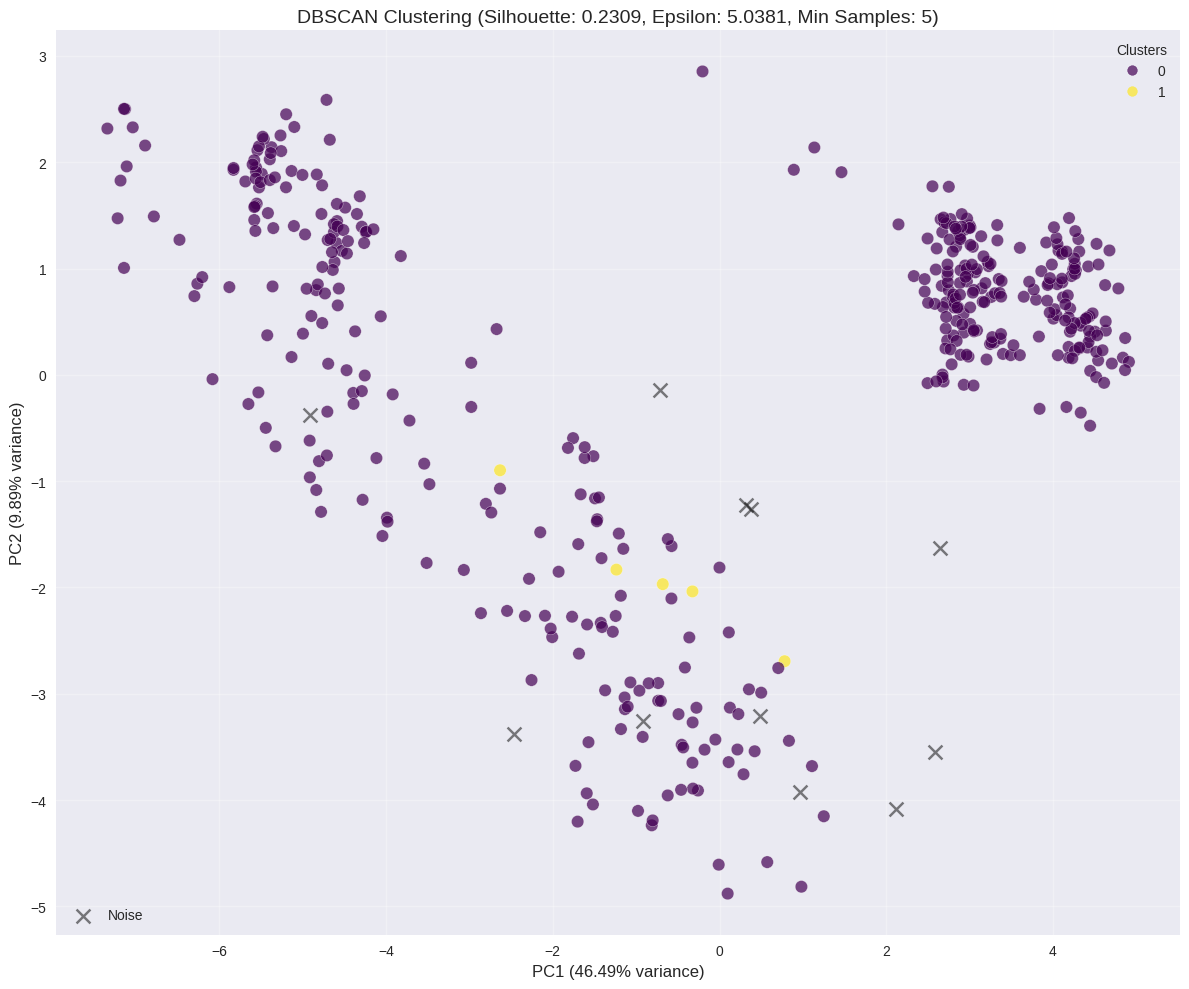


Cluster Centers (Standardized Scale):


,mean,std,min,max,range,high_state_mean,low_state_mean,high_state_ratio,high_state_std,low_state_std,transition_point,transition_magnitude,trend_slope,EPAI_COILC,LARGCOILVISC,Aluminium,Azote,Bore,Carbone,Chrome,Cuivre,Etain,Manganese,Molybdene,Nickel,Niobium,Phosphore,Silicium,Soufre,Titane
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.020,-0.010,0.000,-0.010,-0.010,-0.010,-0.000,-0.010,-0.010,-0.010,-0.010,0.020,0.000,-0.030,-0.010,0.000,0.020,0.040,0.030,0.040,0.000,-0.000,0.020,-0.060,-0.000,-0.090,-0.100,0.030,-0.020,0.030
1,0.610,-0.040,0.370,0.580,-0.070,0.250,0.420,0.290,0.720,-0.300,-0.220,-0.350,-0.000,1.550,0.130,0.050,-1.180,-0.950,-1.280,-1.010,-1.080,-0.860,-0.690,-0.950,-0.800,-0.150,6.060,-0.980,0.040,-0.480


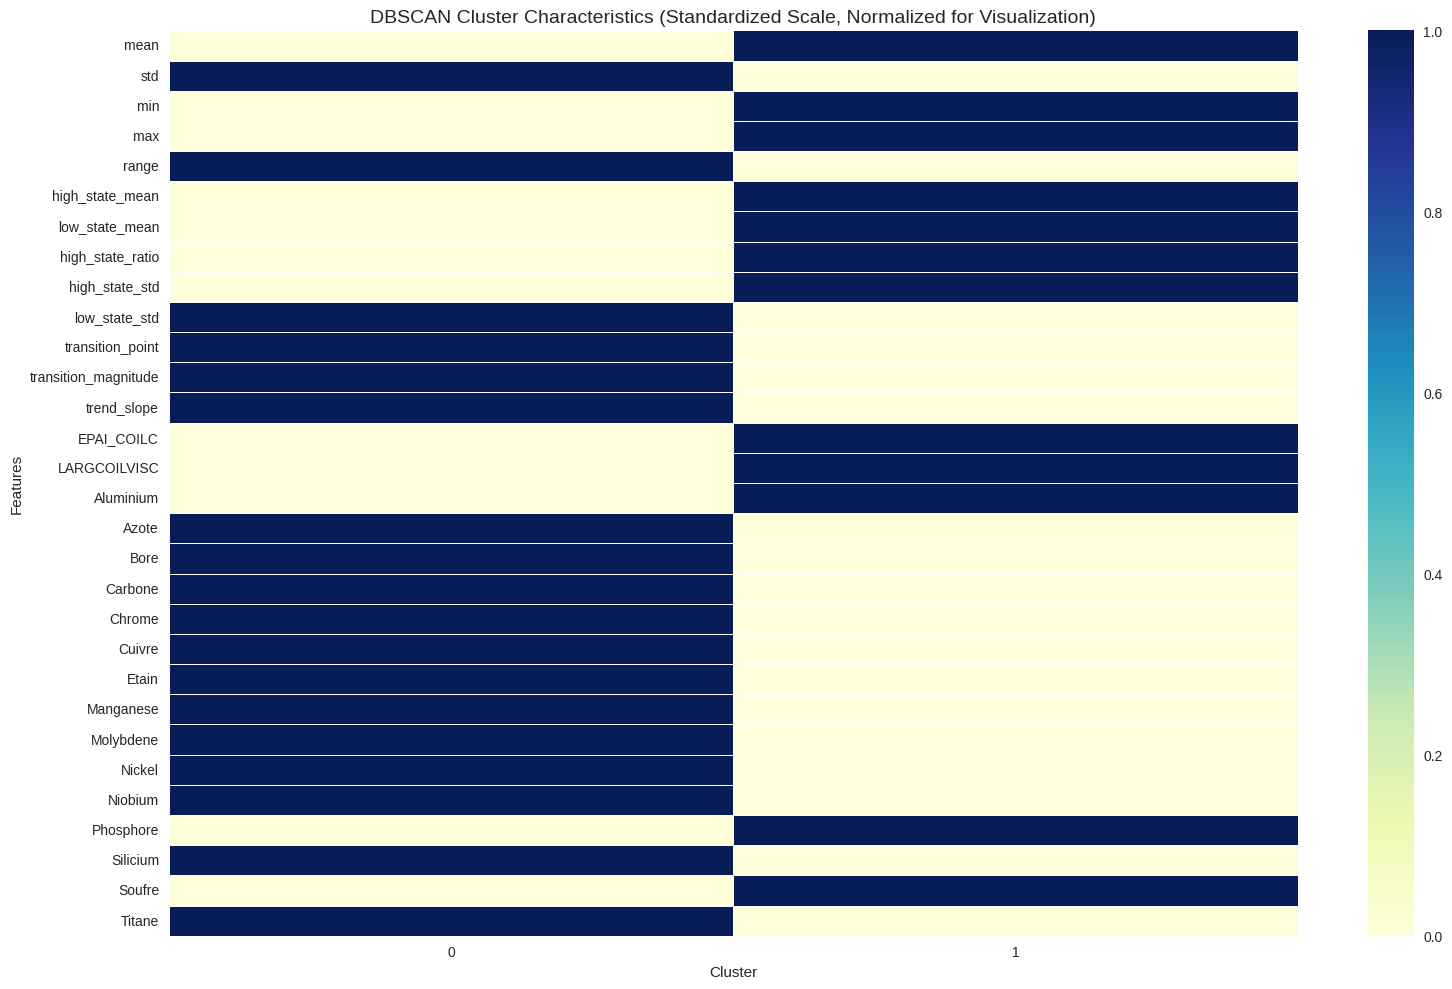

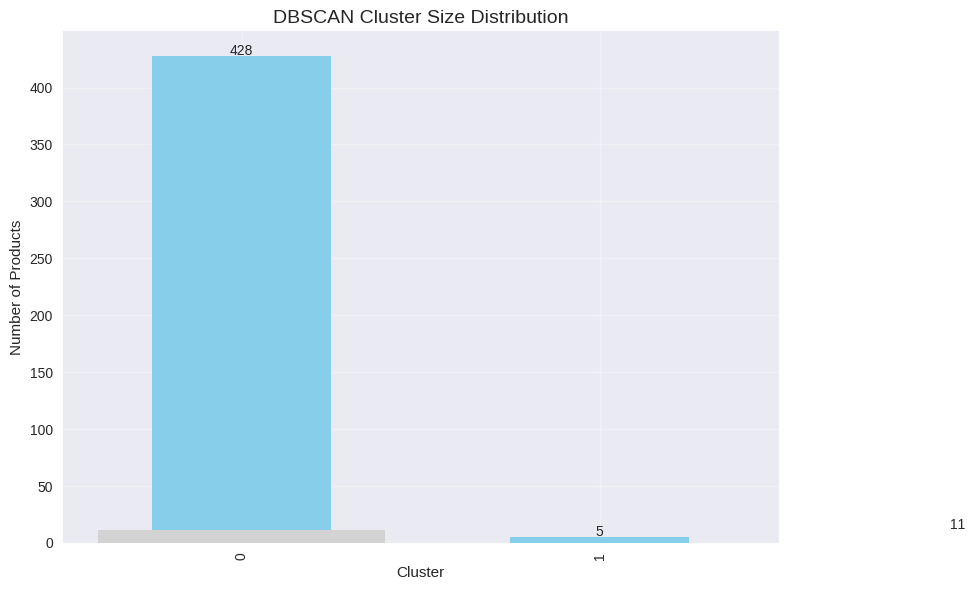

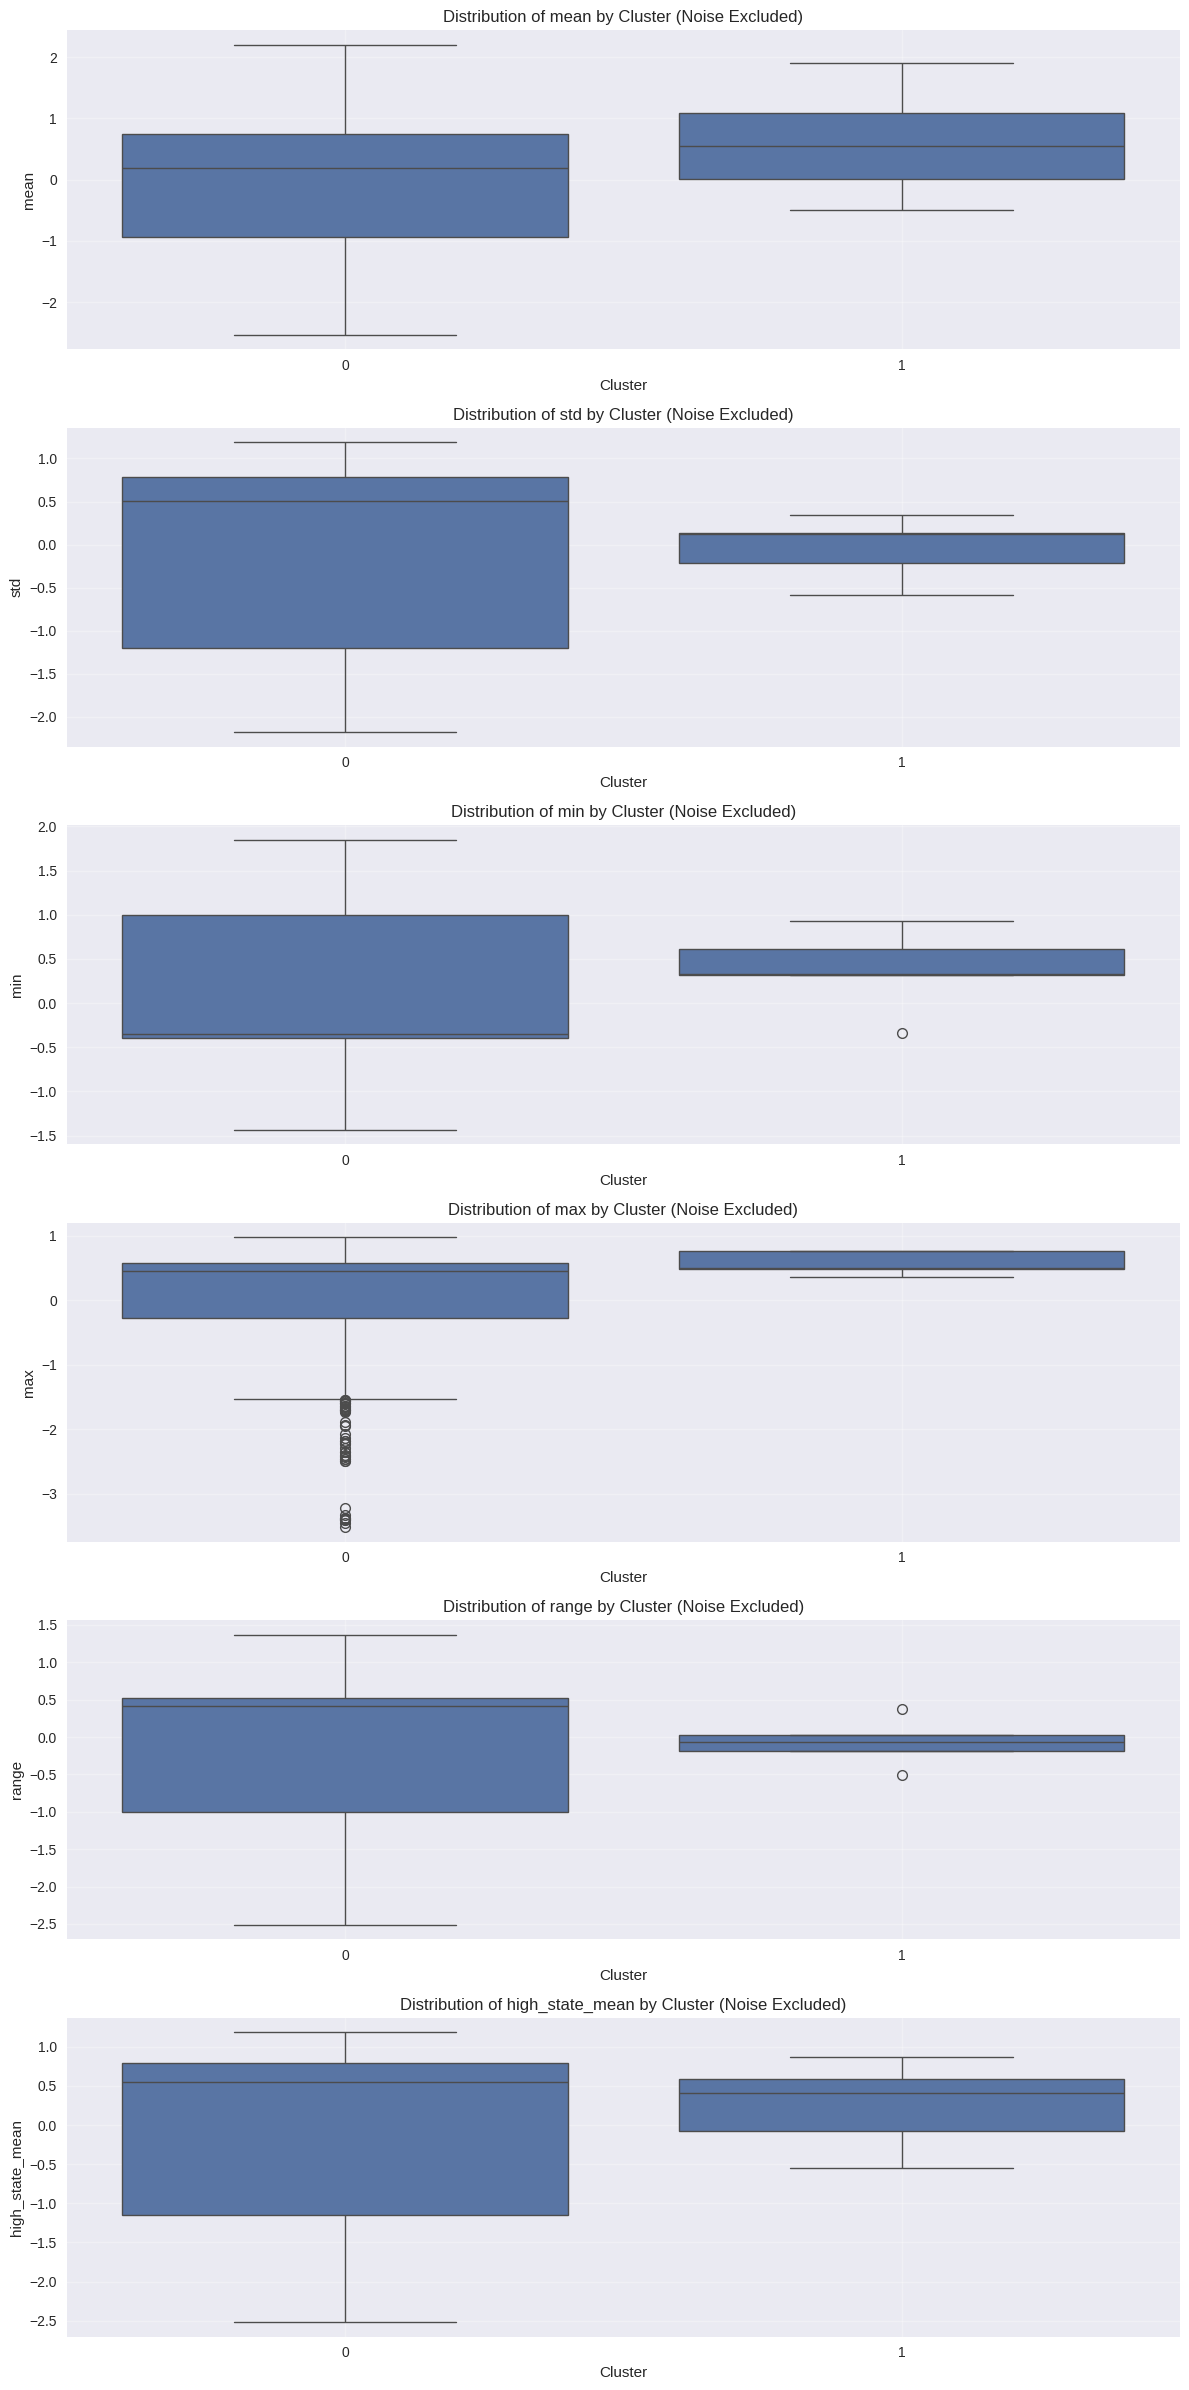

In [22]:
def visualize_dbscan(X_scaled, dbscan_result, selected_features, title_prefix="DBSCAN"):
    """Visualize DBSCAN Clustering results"""
    labels = dbscan_result['labels']
    epsilon = dbscan_result['epsilon']
    min_samples = dbscan_result['min_samples']
    n_clusters = dbscan_result['n_clusters']
    n_noise = dbscan_result['n_noise']

    # 1. PCA Visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(
        data=X_pca,
        columns=['PC1', 'PC2']
    )
    pca_df['cluster'] = labels

    # Plot PCA
    plt.figure(figsize=(12, 10))

    # First plot noise points in black with 'x' marker
    noise_mask = (labels == -1)
    if np.any(noise_mask):
        plt.scatter(
            X_pca[noise_mask, 0],
            X_pca[noise_mask, 1],
            c='black',
            marker='x',
            s=100,
            alpha=0.5,
            label='Noise'
        )

    # Then plot actual clusters
    non_noise_mask = ~noise_mask
    if np.any(non_noise_mask):
        scatter = plt.scatter(
            X_pca[non_noise_mask, 0],
            X_pca[non_noise_mask, 1],
            c=labels[non_noise_mask],
            cmap='viridis',
            s=80,
            alpha=0.7,
            edgecolor='w'
        )

        # Add legend for clusters
        legend1 = plt.legend(*scatter.legend_elements(),
                           title="Clusters",
                           loc="upper right")
        plt.gca().add_artist(legend1)

    # Add a separate legend for noise
    if np.any(noise_mask):
        plt.legend(loc="lower left")

    # Add titles and labels
    if 'silhouette' in dbscan_result and dbscan_result['n_clusters'] > 1:
        plt.title(f'{title_prefix} Clustering (Silhouette: {dbscan_result["silhouette"]:.4f}, '
                f'Epsilon: {epsilon:.4f}, Min Samples: {min_samples})', fontsize=14)
    else:
        plt.title(f'{title_prefix} Clustering (Epsilon: {epsilon:.4f}, Min Samples: {min_samples})', fontsize=14)
    # Create directory if it doesn't exist
    os.makedirs('results/dbscan', exist_ok=True)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/dbscan/dbscan_pca_eps{epsilon:.4f}_min{min_samples}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Only continue with the remaining visualizations if we have clusters
    if n_clusters > 1:
        # 2. Cluster Characteristics Analysis
        # For DBSCAN, we need to calculate cluster centers manually
        # Convert X_scaled to DataFrame for easier manipulation
        X_df = pd.DataFrame(X_scaled, columns=selected_features)
        X_df['cluster'] = labels

        # Filter out noise points (-1)
        X_df_no_noise = X_df[X_df['cluster'] >= 0]

        # Calculate cluster means in scaled space
        centers_df = X_df_no_noise.groupby('cluster')[selected_features].mean()

        # Display scaled centers
        print("\nCluster Centers (Standardized Scale):")
        display(centers_df.round(2))

        # Scale the centers for better visualization (in standardized space)
        centers_scaled = (centers_df - centers_df.min()) / (centers_df.max() - centers_df.min())

        # Heatmap of cluster means
        plt.figure(figsize=(16, 10))
        sns.heatmap(
            centers_scaled.T,
            annot=False,
            cmap="YlGnBu",
            linewidths=0.5
        )
        plt.title(f'{title_prefix} Cluster Characteristics (Standardized Scale, Normalized for Visualization)', fontsize=14)
        plt.ylabel('Features')
        plt.xlabel('Cluster')
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(f'results/dbscan/dbscan_centers_eps{epsilon:.4f}_min{min_samples}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 3. Cluster Size Distribution
        plt.figure(figsize=(10, 6))
        cluster_counts = pd.Series(labels).value_counts().sort_index()

        # Create bar plot - handle noise separately
        ax = plt.subplot()

        # Normal clusters (non-noise)
        non_noise_counts = cluster_counts[cluster_counts.index >= 0]
        non_noise_counts.plot(kind='bar', color='skyblue', ax=ax)

        # Noise points (if any)
        if -1 in cluster_counts.index:
            noise_count = cluster_counts[-1]
            # Add as a separate bar at the end with different color
            ax.bar(['Noise'], [noise_count], color='lightgray')

        # Add count labels
        for i, count in enumerate(non_noise_counts):
            ax.text(i, count + 1, str(count), ha='center')

        if -1 in cluster_counts.index:
            ax.text(len(non_noise_counts), noise_count + 1, str(noise_count), ha='center')

        plt.title(f'{title_prefix} Cluster Size Distribution', fontsize=14)
        plt.xlabel('Cluster')
        plt.ylabel('Number of Products')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'results/dbscan/dbscan_distribution_eps{epsilon:.4f}_min{min_samples}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 4. Feature distributions within clusters
        # Show boxplots for a subset of important features
        important_features = selected_features[:min(6, len(selected_features))]  # First 6 features or less

        # Create a figure with a subplot for each important feature
        fig, axes = plt.subplots(len(important_features), 1, figsize=(12, 4*len(important_features)))

        # Plot boxplots for each feature (excluding noise)
        for i, feature in enumerate(important_features):
            sns.boxplot(x='cluster', y=feature, data=X_df_no_noise, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature} by Cluster (Noise Excluded)')
            axes[i].set_xlabel('Cluster')
            axes[i].set_ylabel(feature)
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'results/dbscan/dbscan_features_eps{epsilon:.4f}_min{min_samples}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Save cluster information
        cluster_info = {
            'centers': centers_df.values,
            'cluster_counts': cluster_counts.to_dict(),
            'epsilon': epsilon,
            'min_samples': min_samples
        }
        np.save(f'results/dbscan/dbscan_info_eps{epsilon:.4f}_min{min_samples}.npy', cluster_info)
    else:
        print("DBSCAN did not find multiple clusters. Skipping cluster analysis visualizations.")

    return pca, X_pca

# Visualize DBSCAN results
pca_dbscan, X_pca_dbscan = visualize_dbscan(X_scaled, dbscan_result, selected_features)

The DBSCAN clustering shows :

- With epsilon=5.0381 and min_samples=5, DBSCAN identifies primarily one large cluster containing 428 products (96.4% of data), with only 5 products in a second cluster and 11 noise points (marked with X). This suggests that the products form one coherent group with a few outliers, rather than two distinct groups.




# 5. Comparison of Clustering Methods


In [31]:
def compare_clustering_methods(X_scaled, clustering_results):
    """Compare different clustering methods with basic metrics only"""
    # Extract methods and scores
    methods = list(clustering_results.keys())
    silhouette_scores = [result['silhouette'] for method, result in clustering_results.items()]

    # Display comparison table
    comparison_data = []
    for method, result in clustering_results.items():
        method_info = {
            'Method': method,
            'Silhouette Score': result['silhouette'],
            'Number of Clusters': result.get('n_clusters', 'N/A')
        }

        # Add DBSCAN-specific info
        if method == 'DBSCAN':
            method_info['Epsilon'] = result.get('epsilon', 'N/A')
            method_info['Min Samples'] = result.get('min_samples', 'N/A')
            method_info['Noise Points'] = result.get('n_noise', 'N/A')

        # Add GMM-specific info
        if method == 'GMM':
            method_info['Covariance Type'] = result.get('covariance_type', 'N/A')

        comparison_data.append(method_info)

    # Create and display comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    print("\nClustering Methods Comparison:")
    print(comparison_df)

    # Find best method by silhouette score
    valid_methods = {k: v for k, v in clustering_results.items() if v['silhouette'] > 0}
    if valid_methods:
        best_method = max(valid_methods.items(), key=lambda x: x[1]['silhouette'])[0]
        print(f"\nBest clustering method based on silhouette score: {best_method} "
              f"(Score: {clustering_results[best_method]['silhouette']:.4f})")
    else:
        best_method = None
        print("\nNo valid clustering method found based on silhouette score.")

    # Print cluster sizes for each method
    print("\nCluster sizes by method:")
    for method, result in clustering_results.items():
        labels = result['labels']

        # Handle DBSCAN specially due to noise points
        if method == 'DBSCAN':
            value_counts = pd.Series(labels).value_counts().sort_index()
            # Check if noise points exist
            if -1 in value_counts.index:
                noise_count = value_counts[-1]
                value_counts = value_counts[value_counts.index != -1]
                cluster_sizes = ', '.join([f"Cluster {i}: {count}" for i, count in enumerate(value_counts)])
                print(f"{method}: {cluster_sizes}, Noise: {noise_count}")
            else:
                cluster_sizes = ', '.join([f"Cluster {i}: {count}" for i, count in enumerate(value_counts)])
                print(f"{method}: {cluster_sizes}")
        else:
            value_counts = pd.Series(labels).value_counts().sort_index()
            cluster_sizes = ', '.join([f"Cluster {i}: {count}" for i, count in enumerate(value_counts)])
            print(f"{method}: {cluster_sizes}")

    return best_method

# Create clustering results dictionary
clustering_results = {
    'KMeans': kmeans_result,
    'GMM': gmm_result,
    'DBSCAN': dbscan_result
}

# Compare clustering methods with simple analysis
best_method = compare_clustering_methods(X_scaled, clustering_results)


Clustering Methods Comparison:
   Method  Silhouette Score  Number of Clusters Covariance Type  Epsilon  \
0  KMeans             0.370                   2             NaN      NaN   
1     GMM             0.370                   2            tied      NaN   
2  DBSCAN             0.231                   2             NaN    5.038   

   Min Samples  Noise Points  
0          NaN           NaN  
1          NaN           NaN  
2        5.000        11.000  

Best clustering method based on silhouette score: KMeans (Score: 0.3702)

Cluster sizes by method:
KMeans: Cluster 0: 225, Cluster 1: 219
GMM: Cluster 0: 219, Cluster 1: 225
DBSCAN: Cluster 0: 428, Cluster 1: 5, Noise: 11


### Clustering Comparison Analysis

**Silhouette Scores**
- KMeans: 0.370 (highest)
- GMM: 0.370 (tied with KMeans)
- DBSCAN: 0.231 (significantly lower)

**Cluster Distributions**
- **KMeans**: Two balanced clusters (225 and 219 products)
- **GMM**: Two balanced clusters (219 and 225 products) - essentially the same as KMeans but with cluster labels swapped
- **DBSCAN**: Highly imbalanced with one dominant cluster (428 products), one tiny cluster (5 products), and 11 noise points

**Insights**

1. **KMeans and GMM Agreement**: These methods identified virtually identical groupings, which strongly validates the presence of two natural clusters in your data. The only difference is the arbitrary cluster labeling (0 vs 1).

2. **DBSCAN's Different Perspective**: While distance-based methods (KMeans, GMM) found two balanced clusters, density-based DBSCAN interprets your data as having one primary manufacturing group with a few outliers.

3. **Noise Detection**: Only DBSCAN identified 11 products as noise (outliers), which could represent anomalous steel products requiring special attention or quality control measures.

4. **Best Method**: KMeans is technically the best method based on silhouette score (0.3702), though GMM (0.3696) is essentially identical in performance.
